# NBA Shot Prediction

## Jose M. Albornoz
### October 18th, 2022 


# 0.- Imports and settings

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib import cm
style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams["figure.figsize"] = (8,6)

import seaborn as sns

import random
import time
from statistics import mean, stdev

from sklearn.model_selection import train_test_split

# maximum number of dataframe rows and columns displayed
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 50)

RANDOM_STATE = 801
pd.options.mode.chained_assignment = None

import os
os.environ['PYTHONWARNINGS'] = 'ignore'

# 1.- Business proposition

The business use case addressed in this notebook is related to sport analytics and scientific betting (if you want to know more about this area, please have a look at [The Perfect Bet, by Adam Kucharski](https://www.amazon.co.uk/Perfect-Bet-Science-Taking-Gambling/dp/0465055958))

We will consider **NBA basketball games** - we are interested in predicting the outcome of a shot taken by a player: **will the shot be made or will it be missed?** 

* Can we consistently predict the outcome of a shot?
* What are the factors that determine if a shot will be made?

Answering these questions may lead to a profitable automated betting strategy.

We are also interested in gaining insights that can inform how players in a team could be selected  for maximum performance (as well as informing possible game strategies) by answering the following questions:

* Are there players who are consistently effective at making shots?
* Are there players who are consistently effective at preventing shots from being made?
* Are there combinations of teams in a game in which one of the teams is consistently good at making shots? This could be an indication not only of individual player performance but team performance.
* Are there combinations of teams in a game in which one team is consistently good at preventing shots from being made? Again, this could be an indication not only of individual defenders' performance but team performance.
* Are there any other insights that could complement our domain knowledge?

In order to address the above questions, we have a dataset for a series of NBA games containing player-by-player information; the dataset describes attempted shots and the outcome (made/missed) together with other factors that may influence the outcome of the shot. 

The data used to create the dataset is freely available and can be downloaded from [https://www.nba.com/stats](https://www.nba.com/stats)

# 2.- Load dataset 

In [2]:
shotData = pd.read_csv('shot_logs_wed.csv')

In [3]:
shotData.shape

(26315, 21)

The dataset has 26315 rows and 21 columns; each row represents a shot attempted by a particular NBA player at a given match. 

In [4]:
# view first few rows of the data
shotData.head()

,GAME_ID,MATCHUP,LOCATION,W,FINAL_MARGIN,SHOT_NUMBER,PERIOD,GAME_CLOCK,SHOT_CLOCK,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_name,player_id
0,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,1,1,01:09:00,10.8,2,1.9,7.7,2,made,"Anderson, Alan",101187,1.3,1,2,brian roberts,203148
1,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,2,1,00:14:00,3.4,0,0.8,28.2,3,missed,"Bogdanovic, Bojan",202711,6.1,0,0,brian roberts,203148
2,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,3,1,00:00:00,NaN,3,2.7,10.1,2,missed,"Bogdanovic, Bojan",202711,0.9,0,0,brian roberts,203148
3,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,4,2,11:47:00,10.3,2,1.9,17.2,2,missed,"Brown, Markel",203900,3.4,0,0,brian roberts,203148
4,21400899,"MAR 04, 2015 - CHA @ BKN",A,W,24,5,2,10:34:00,10.9,2,2.7,3.7,2,missed,"Young, Thaddeus",201152,1.1,0,0,brian roberts,203148


## 2.1.- Data dictionary

The target we want to predict is represented by the column labeled **SHOT_RESULT**; its values can be **made** or **missed**. 

The features that are available to build a predictive model are:

* **GAME_ID**: self-explanatory
* **MATCHUP**: date of the game and teams
* **LOCATION**: Home (H) or Away (H). Indicates which team is playing at home and which team is a visitor.
* **W**: Win (W) or Lose (L) for each team
* **FINAL_MARGIN**: outcome of the game, in points
* **SHOT_NUMBER**: a number to identify each shot attempted by a player
* **PERIOD**: any of the periods in which the matchup is divided. In the NBA, a period lasts for 12 minutes, except for overtime periods that last for 5 minutes
* **GAME_CLOCK**: a timer to keep track of the amount of time left in the current period, in minutes and seconds
* **SHOT_CLOCK**: a timer to keep track of the amount of time left to attempt a shot - a player has 24 seconds to take the shot once in possession of the ball
* **DRIBBLES**: number of dribbles made by the player once in possession of the ball
* **TOUCH_TIME**: time that the player holds the ball before taking a shot or passing the ball
* **SHOT_DIST**: distance to the hoop when taking the shot
* **PTS_TYPE**: points that are awarded if the shot is made: either 2 or 3 points
* **CLOSEST_DEFENDER**: name of the closest defender
* **CLOSEST_DEFENDER_PLAYER_ID**: self-explanatory
* **CLOSE_DEF_DIST**: distance between the player taking the shot and the closest defender
* **FGM**: field goal made - was the shot made? 1 if yes, 0 otherwise.
* **PTS**: points made by the player when taking the shot. Can be 0, 2 or 3
* **player_name**: name of the player attempting the shot
* **player_id**: self-explanatory

## 2.2.- Feature types

In [5]:
shotData.dtypes

GAME_ID                         int64
MATCHUP                        object
LOCATION                       object
W                              object
FINAL_MARGIN                    int64
SHOT_NUMBER                     int64
PERIOD                          int64
GAME_CLOCK                     object
SHOT_CLOCK                    float64
DRIBBLES                        int64
TOUCH_TIME                    float64
SHOT_DIST                     float64
PTS_TYPE                        int64
SHOT_RESULT                    object
CLOSEST_DEFENDER               object
CLOSEST_DEFENDER_PLAYER_ID      int64
CLOSE_DEF_DIST                float64
FGM                             int64
PTS                             int64
player_name                    object
player_id                       int64
dtype: object

We have the following breakdown for the types of features we are dealing with:

* 10 integer features
* 4 floating point features
* 6 text features, one of which represents a timestamp.
* 1 text-based target

## 2.3.- Unique values per feature

In [6]:
shotData.nunique()

GAME_ID                       187
MATCHUP                       374
LOCATION                        2
W                               2
FINAL_MARGIN                   58
SHOT_NUMBER                    36
PERIOD                          7
GAME_CLOCK                    718
SHOT_CLOCK                    241
DRIBBLES                       31
TOUCH_TIME                    248
SHOT_DIST                     371
PTS_TYPE                        2
SHOT_RESULT                     2
CLOSEST_DEFENDER              443
CLOSEST_DEFENDER_PLAYER_ID    444
CLOSE_DEF_DIST                220
FGM                             2
PTS                             3
player_name                   281
player_id                     281
dtype: int64

Comparing the number of unique values for each feature with the number of rows in the dataset (26,315), it makes sense to consider text features as categorical features, with the exception of **SHOT_CLOCK**, which, as previously mentioned, represents a timestamp.

## 2.4.- Missing values

In [7]:
shotData.isnull().sum()

GAME_ID                          0
MATCHUP                          0
LOCATION                         0
W                                0
FINAL_MARGIN                     0
SHOT_NUMBER                      0
PERIOD                           0
GAME_CLOCK                       0
SHOT_CLOCK                    1047
DRIBBLES                         0
TOUCH_TIME                       0
SHOT_DIST                        0
PTS_TYPE                         0
SHOT_RESULT                      0
CLOSEST_DEFENDER                 0
CLOSEST_DEFENDER_PLAYER_ID       0
CLOSE_DEF_DIST                   0
FGM                              0
PTS                              0
player_name                      0
player_id                        0
dtype: int64

In [8]:
shotData.isnull().sum()*100/shotData.shape[0]

GAME_ID                       0.000000
MATCHUP                       0.000000
LOCATION                      0.000000
W                             0.000000
FINAL_MARGIN                  0.000000
SHOT_NUMBER                   0.000000
PERIOD                        0.000000
GAME_CLOCK                    0.000000
SHOT_CLOCK                    3.978719
DRIBBLES                      0.000000
TOUCH_TIME                    0.000000
SHOT_DIST                     0.000000
PTS_TYPE                      0.000000
SHOT_RESULT                   0.000000
CLOSEST_DEFENDER              0.000000
CLOSEST_DEFENDER_PLAYER_ID    0.000000
CLOSE_DEF_DIST                0.000000
FGM                           0.000000
PTS                           0.000000
player_name                   0.000000
player_id                     0.000000
dtype: float64

The only feature with missing values is **SHOT_CLOCK** with 3.79% missing values; we will later explore ways to impute these missing values.

# 3.- Exploratory data analysis: Part A

Let's begin by spliting the dataset into the target and the features we will use for prediction:

In [9]:
target_name = "SHOT_RESULT"
data0, target = shotData.drop(columns=target_name), shotData[target_name]

## 3.1.- Target analysis

Let's examine the distribution of values for the prediction target

In [10]:
target.value_counts()*100/data0.shape[0]

missed    55.246057
made      44.753943
Name: SHOT_RESULT, dtype: float64

Text(0, 0.5, 'Percentage of shots')

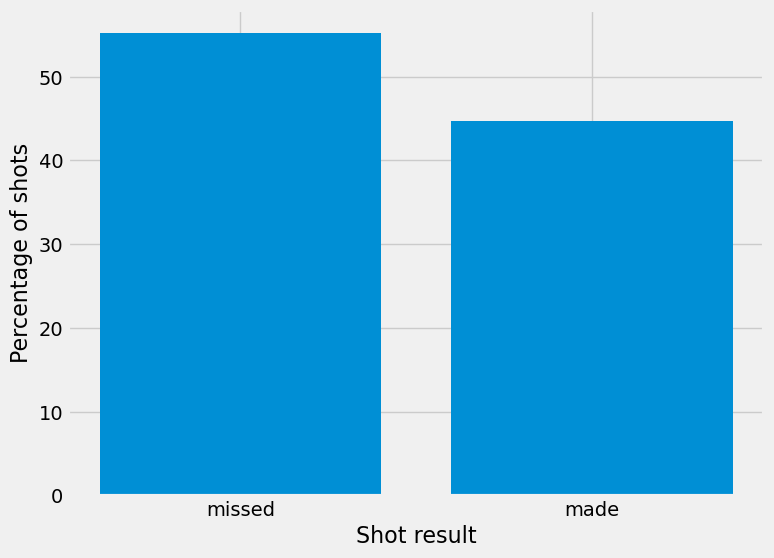

In [11]:
plt.bar(['missed', 'made'], target.value_counts()*100/data0.shape[0])
plt.xlabel('Shot result', fontsize=16)
plt.ylabel('Percentage of shots', fontsize=16)

We see that almost 45% of the shots are made - we are talking about NBA players! 

## 3.2.- Feature analysis

We will examine in detail the features that will be used to train a predictive model. Let's begin by splitting the features into numerical and categorical: 

In [12]:
from sklearn.compose import make_column_selector as selector

numerical_columns_selector = selector(dtype_exclude=object)
categorical_columns_selector = selector(dtype_include=object)

numerical_columns = numerical_columns_selector(data0)
categorical_columns = categorical_columns_selector(data0)

### 3.2.1.- Numerical features

In [13]:
numerical_columns

['GAME_ID',
 'FINAL_MARGIN',
 'SHOT_NUMBER',
 'PERIOD',
 'SHOT_CLOCK',
 'DRIBBLES',
 'TOUCH_TIME',
 'SHOT_DIST',
 'PTS_TYPE',
 'CLOSEST_DEFENDER_PLAYER_ID',
 'CLOSE_DEF_DIST',
 'FGM',
 'PTS',
 'player_id']

<font size="4">**GAME_ID**:</font>

In [14]:
data0['GAME_ID'].nunique()

187

We observe that we have data for 187 games. 


<font size="4">**FINAL_MARGIN**:</font>

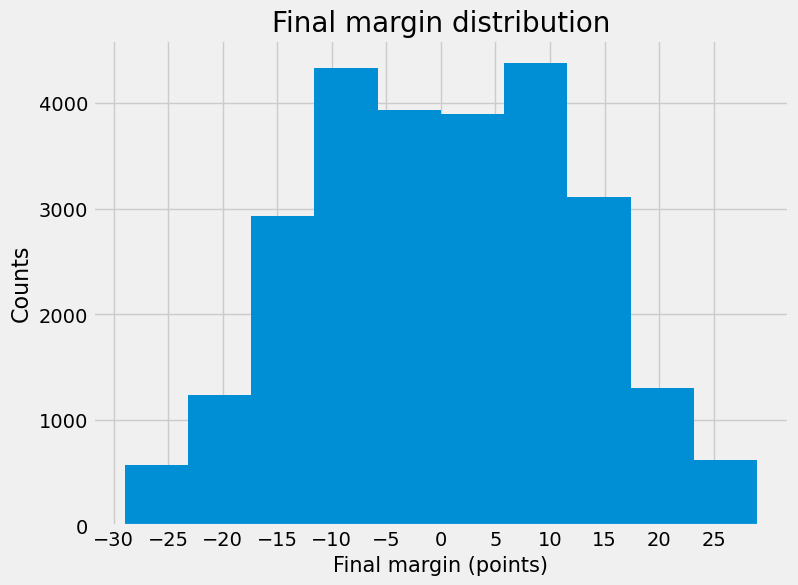

In [15]:
data0['FINAL_MARGIN'].hist()
plt.xlabel('Final margin (points)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Final margin distribution', fontsize=20)
plt.xticks(np.arange(-30, 30, 5.0));

ANSWER: DataRobot doesn't blindly use the same metrics in every project. The metrics available depend ont he attributes of the target features. Does it suggest Regression or Classification? Weighted or not-weighted? Normal distribution or skewed in some way?

In [16]:
data0['FINAL_MARGIN'].describe()

count    26315.000000
mean         0.205624
std         12.165785
min        -29.000000
25%         -8.000000
50%          1.000000
75%          9.000000
max         29.000000
Name: FINAL_MARGIN, dtype: float64

The distribution for the final margin is symmetrical: for each matchup, the winner's margin in points is positive, while this same margin is negative for the loser; each matchup is a zero-sum game. In most cases, the matchup is either won or lost by some 10~12 points. 


<font size="4">**SHOT_NUMBER**:</font>

Text(0.5, 1.0, 'Shot number distribution')

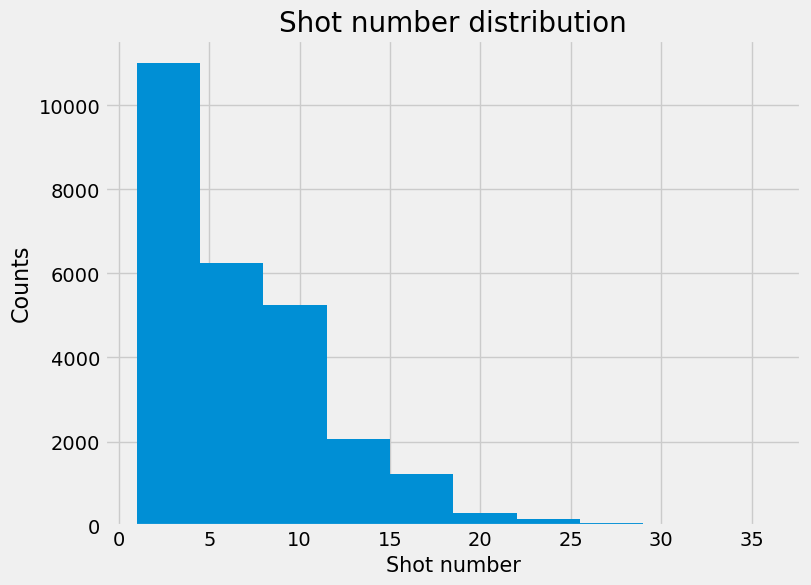

In [17]:
data0['SHOT_NUMBER'].hist()
plt.xlabel('Shot number', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Shot number distribution', fontsize=20)

As such, this plot is not very useful; we would rather like to know how many shots each player takes per game.

In [18]:
shotsPerPlayerPerGame = data0.groupby(['GAME_ID','player_id']).agg(
                              numShots = ("SHOT_NUMBER", "max")
)

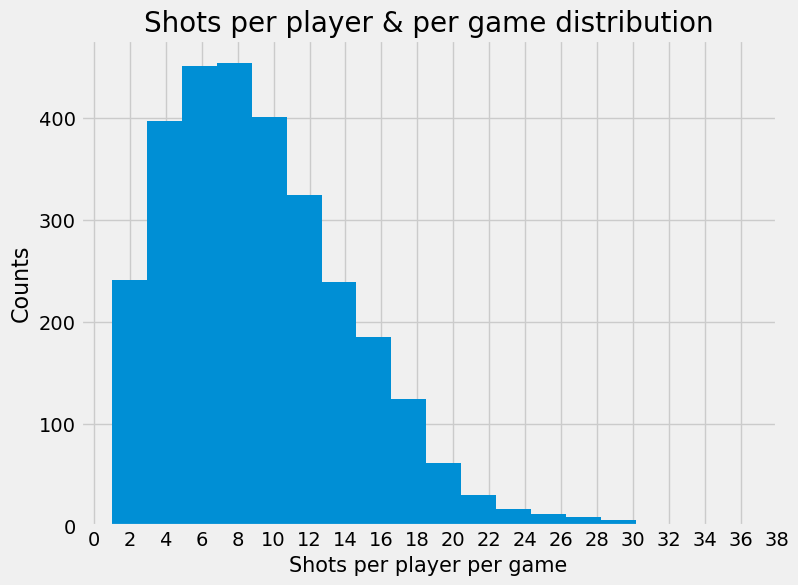

In [19]:
shotsPerPlayerPerGame.hist(bins=18)
plt.xlabel('Shots per player per game', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Shots per player & per game distribution', fontsize=20)
plt.xticks(np.arange(0, 40, 2.0));

In [20]:
shotsPerPlayerPerGame.describe()

,numShots
count,2950.000000
mean,8.925085
std,5.208193
min,1.000000
25%,5.000000
50%,8.000000
75%,12.000000
max,36.000000


Most players take some 8-9 shots per game. Any number of shots larger than 12 falls within the upper quartile of the distribution.


<font size="4">**PERIOD**:</font>

Text(0.5, 1.0, 'Periods per game distribution')

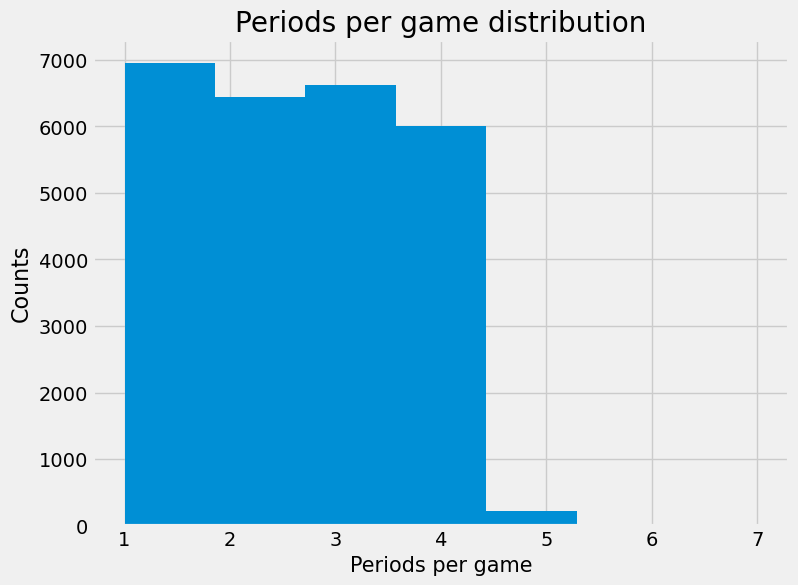

In [21]:
data0['PERIOD'].hist(bins=7)
plt.xlabel('Periods per game', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Periods per game distribution', fontsize=20)

A NBA basketball game normally is played in four 12-minutes periods; if there is a tie, additional 5-minutes periods take place. We see that the vast majority of the matchups end after 4 periods.


<font size="4">**SHOT_CLOCK**:</font>

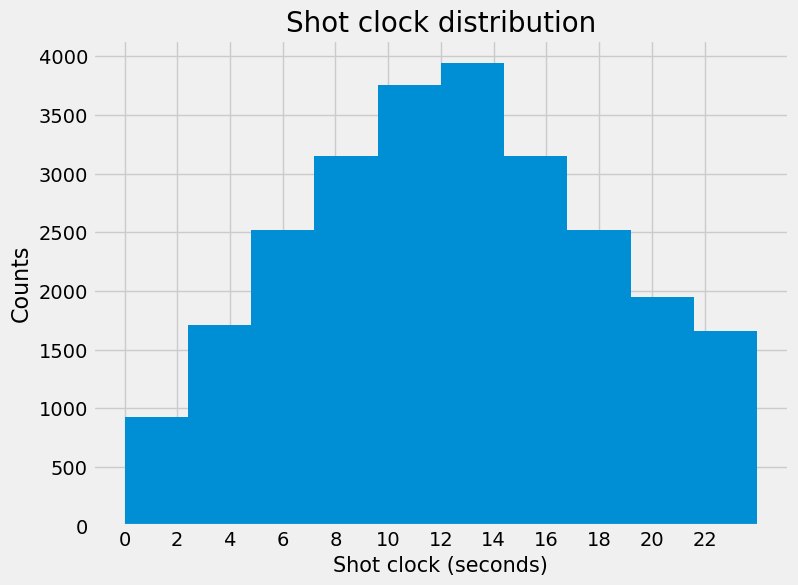

In [22]:
data0['SHOT_CLOCK'].hist()
plt.xlabel('Shot clock (seconds)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Shot clock distribution', fontsize=20)
plt.xticks(np.arange(0, 24, 2.0));

In [23]:
data0['SHOT_CLOCK'].describe()

count    25268.000000
mean        12.390205
std          5.776581
min          0.000000
25%          8.100000
50%         12.300000
75%         16.500000
max         24.000000
Name: SHOT_CLOCK, dtype: float64

Most shots are taken halfway through the 24-seconds shot window; the distribution of the times left to take the shot is symmetrical around this 12-seconds value. The number of missing values for this feature represents almost 4% of the data - we see that it would make sense to take the median value (12.3) to impute those missing values.

In [24]:
# impute missing values for SHOT_CLOCK
shotData['SHOT_CLOCK'].fillna(shotData['SHOT_CLOCK'].median(), inplace=True)


<font size="4">**DRIBBLES**:</font>

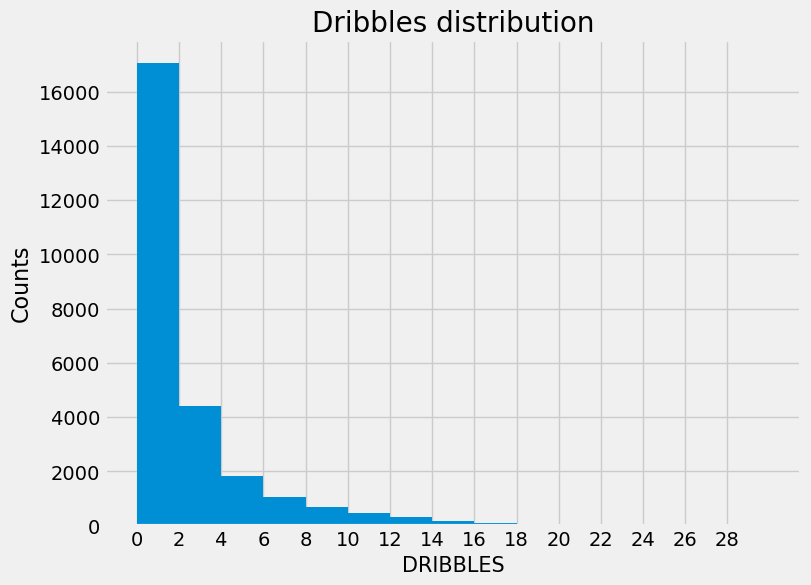

In [25]:
data0['DRIBBLES'].hist(bins=15)
plt.xlabel('DRIBBLES', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Dribbles distribution', fontsize=20)
plt.xticks(np.arange(0, 30, 2.0));

Most of the of shots are taken after at most a couple of dribbles - not surprising, knowing that the player has to take the shot within the 24-seconds window.


<font size="4">**TOUCH_TIME**:</font>

This feature represents the average time a player holds the ball before passing or taking a shot; it was found that this feature contains negative values (which do not make physical sense), corresponding to 0.22% of the values. This is likely a data entry error.

We will impute these values by converting them to positive ones.

In [26]:
data0[data0['TOUCH_TIME'] < 0]['TOUCH_TIME'].count()*100/data0.shape[0]

0.22040661219836596

In [27]:
# replace negative values in TOUCH_TIME 
data0['TOUCH_TIME'] = np.where(data0['TOUCH_TIME'] < 0, np.abs(data0['TOUCH_TIME']), data0['TOUCH_TIME'])

Text(0.5, 1.0, 'Touch time distribution')

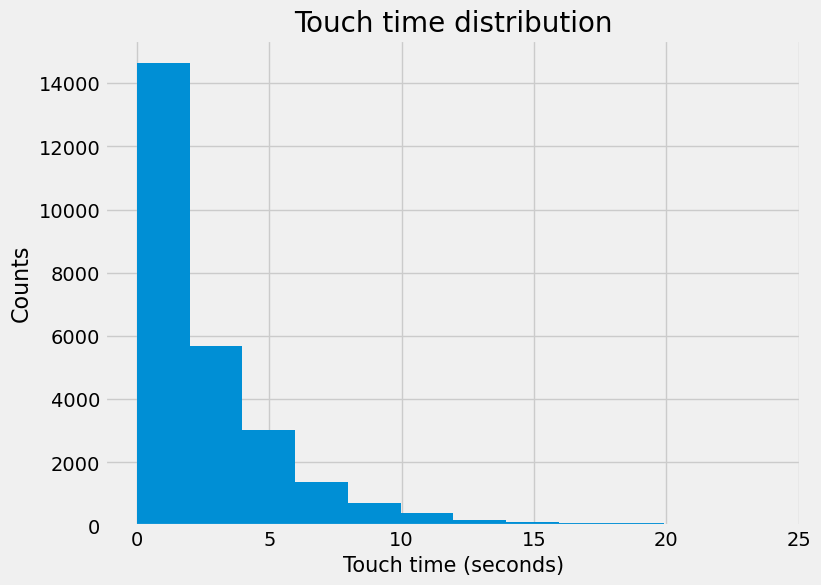

In [28]:
data0['TOUCH_TIME'].hist(bins=12)
plt.xlabel('Touch time (seconds)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Touch time distribution', fontsize=20)

In [29]:
data0['TOUCH_TIME'].describe()

count    26315.000000
mean         2.738358
std          2.933524
min          0.000000
25%          0.900000
50%          1.600000
75%          3.700000
max         23.900000
Name: TOUCH_TIME, dtype: float64

In average, players hold the ball for 2-3 seconds; the distribution tapers off quickly as the touch time increases. Not surprising considering how fast-paced NBA games are!


<font size="4">**SHOT_DIST**:</font>

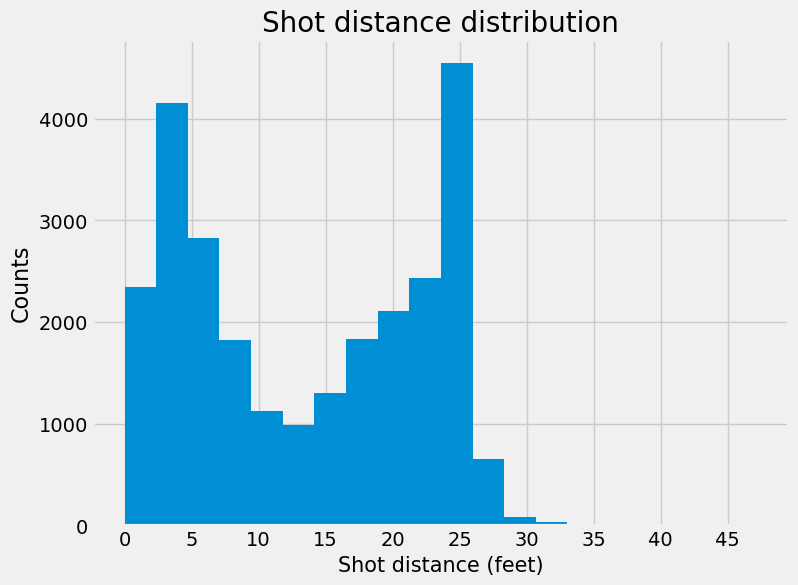

In [30]:
data0['SHOT_DIST'].hist(bins=20)
plt.xlabel('Shot distance (feet)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Shot distance distribution', fontsize=20)
plt.xticks(np.arange(0, 50, 5.0));

In [31]:
data0['SHOT_DIST'].describe()

count    26315.000000
mean        13.652054
std          8.865105
min          0.000000
25%          4.800000
50%         13.900000
75%         22.600000
max         47.200000
Name: SHOT_DIST, dtype: float64

Here's another interesting distribution: players tend to take shots that are either close to the hoop (around 
4 feet away) or far removed from the hoop (around 25 feet away). This is related to the way points are awarded to shots: shots made from distances greater than 23.75 feet from the hoop get 3 points - there is therefore an incentive for these long shots. On the other hand, and owing to the dynamics of the game, players tend to agglomerate close to the hoop, where they get 2 points if the shot is made.


<font size="4">**PTS_TYPE**:</font>

In [32]:
data0['PTS_TYPE'].value_counts()*100/data0.shape[0]

2    73.136994
3    26.863006
Name: PTS_TYPE, dtype: float64

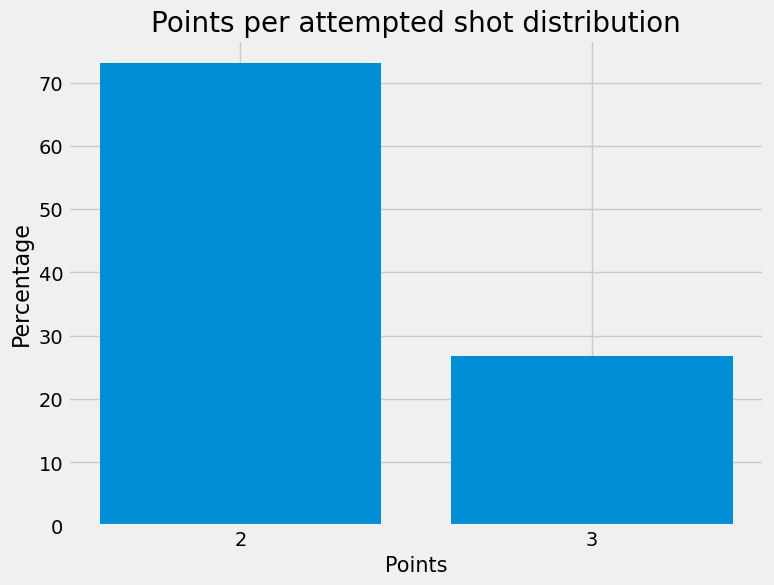

In [33]:
plt.bar(data0['PTS_TYPE'].value_counts().index, data0['PTS_TYPE'].value_counts()*100/data0.shape[0])
plt.xlabel('Points', fontsize=15)
plt.ylabel('Percentage', fontsize=16)
plt.title('Points per attempted shot distribution', fontsize=20)
plt.xticks([2, 3]);

A shot is worth 2 points if it is made from a distance from the hoop less than 23.75 feet; 73% the attempted shots fall in this category. Shots attempted from larger distances (26%) are worth 3 points - there are players who specialise in taking these long-range shots on account of this incentive.


<font size="4">**CLOSE_DEF_DIST**:</font>

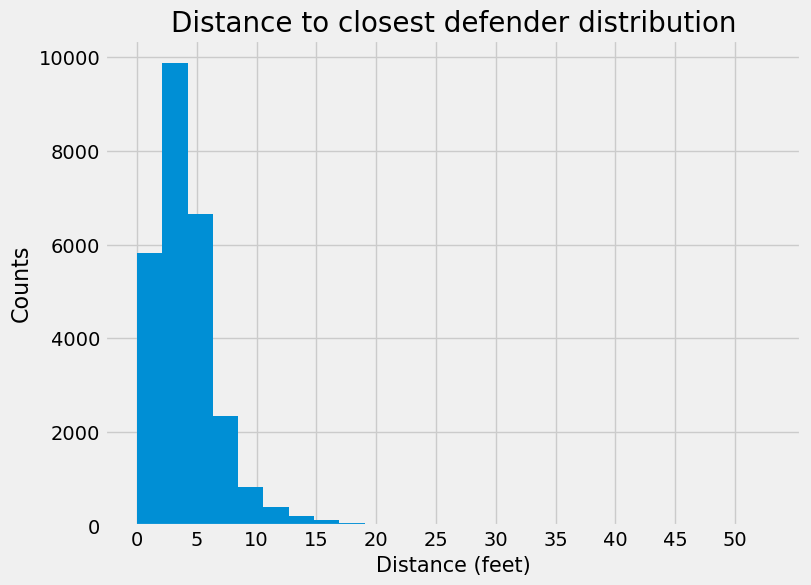

In [34]:
data0['CLOSE_DEF_DIST'].hist(bins=25)
plt.xlabel('Distance (feet)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Distance to closest defender distribution', fontsize=20)
plt.xticks(np.arange(0, 55, 5.0));

In [35]:
data0['CLOSE_DEF_DIST'].describe()

count    26315.000000
mean         4.150241
std          2.772926
min          0.000000
25%          2.300000
50%          3.700000
75%          5.300000
max         52.900000
Name: CLOSE_DEF_DIST, dtype: float64

The above plot makes a lot of sense: defenders will try to position themselves close to the player with the ball - most of them are just some 4 feet away from the player taking the shot.


<font size="4">**FGM**:</font>

Field goal made is nothing more than a proxy for **SHOT_RESULT**: 1 if the shot is made, 0 if the shot is missed.

In [36]:
target.value_counts()

missed    14538
made      11777
Name: SHOT_RESULT, dtype: int64

In [37]:
data0['FGM'].value_counts()

0    14538
1    11777
Name: FGM, dtype: int64

Since FGM is numerical, it makes a better target for prediction purposes - hence we will drop **SHOT_RESULT** from the dataset, and use **FGM** as a target instead.

In [38]:
# drop SHOT_RESULT from the dataset
shotData.drop(columns='SHOT_RESULT', inplace=True)


<font size="4">**PTS**:</font>

In [39]:
data0['PTS'].value_counts()*100/data0.shape[0]

0    55.246057
2    35.337260
3     9.416683
Name: PTS, dtype: float64

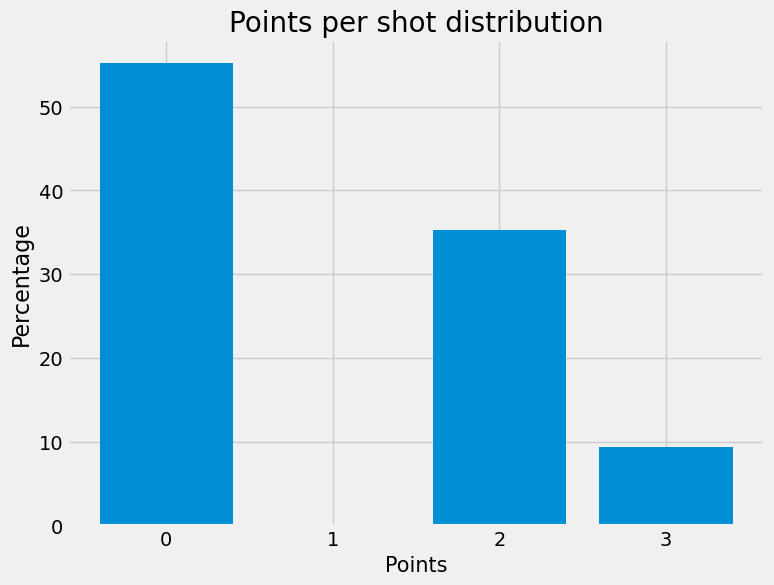

In [40]:
plt.bar(data0['PTS'].value_counts().index, data0['PTS'].value_counts()*100/data0.shape[0])
plt.xlabel('Points', fontsize=15)
plt.ylabel('Percentage', fontsize=16)
plt.title('Points per shot distribution', fontsize=20)
plt.xticks([0, 1, 2, 3]);

Out of the 45% of the shots that are made, 35% correspond to short-range 2-pointers, whilst 9% goes to long-range 3-pointers. This is intuitive: the farther away from the hoop, the more difficult it is to make the shot. Only free shots are worth one point - those are not included in the dataset.

Aside from **GAME_ID**, there are two other numerical features that identify particular players: **player_id** and **CLOSEST_DEFENDER_PLAYER_ID**; these two features could be used as proxies for the text features that contain player names. Before doing that, let's check if there is a one-to-one correspondence between names and IDs:

In [41]:
data0['player_id'].nunique()

281

In [42]:
data0['player_name'].nunique()

281

In [43]:
data0['CLOSEST_DEFENDER_PLAYER_ID'].nunique()

444

In [44]:
data0['CLOSEST_DEFENDER'].nunique()

443

The above mismatch for defenders indicates that one defender is associated to two different IDs! Hence, we will drop **player_id** and **CLOSEST_DEFENDER_PLAYER_ID** and use the names of the players instead: **player_name** and **CLOSEST_DEFENDER**. Given the above checks, we are satisfied that both players and defenders have unique names. 

In [45]:
shotData.drop(columns=['player_id', 'CLOSEST_DEFENDER_PLAYER_ID'], inplace=True)

Before we move on, let's remember that we have a text feature (**GAME_CLOCK**) that represents a timestamp; this timestamp is expressed in minutes, seconds and milliseconds. An examination of the data shows us that the milliseconds portion of this timestamp is always zero.

In [46]:
# express timestamp as timedelta
gameClock = pd.to_timedelta(data0['GAME_CLOCK'])

In [47]:
# express time as float in minutes and fractions of a minute
gameClock = gameClock/pd.offsets.Hour(1)

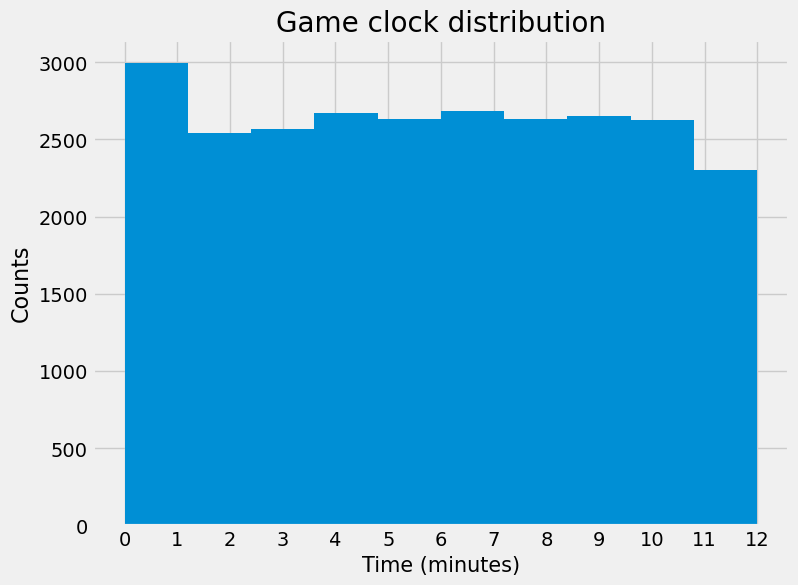

In [48]:
gameClock.hist()
plt.xlabel('Time (minutes)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Game clock distribution', fontsize=20)
plt.xticks(np.arange(0, 13, 1.0));

The above distribution shows us that there are slightly more shots during the last minute of a period, and slightly less during the first minute. 

We will incorporate this transformation from string to time in the original dataset:

In [49]:
# convert GAME_CLOCK string to minutes
shotData['GAME_CLOCK'] = pd.to_timedelta(shotData['GAME_CLOCK'])/pd.offsets.Hour(1)

### 3.2.2.- Categorical features

In [50]:
categorical_columns

['MATCHUP', 'LOCATION', 'W', 'GAME_CLOCK', 'CLOSEST_DEFENDER', 'player_name']


<font size="4">**MATCHUP**:</font>

**MATCHUP** contains the date of the game and the teams that participated. We already know that there are 187 games represented in the dataset, however **MATCHUP** takes into account the fact that one of the teams plays at its home location, whilst the other team plays at an away location. In other words, for any given game the data will present the shots taken by each of the two teams in any given matchup. That's why the number of unique values in **MATCHUP** is double the number of games computed from **GAME_ID**:

In [51]:
data0['MATCHUP'].nunique()

374


<font size="4">**LOCATION**:</font>

**LOCATION** describes which team is hosting the game by playing at its home location (H), and which team is a visitor playing at an away location (H). 

For example, 
* for matchup "NOV 12, 2014 - DEN vs. POR", Denver has Home location, and the corresponding rows with location 'H"  will contain data for the shots taken by Denver. 
* for this same matchup we see "NOV 12, 2014 - POR @ DEN", Portland has away (A) location; the corresponding rows contain shots taken by Portland.  


<font size="4">**W**:</font>

This feature indicates which team won (W) and which team lost (L) any given matchup.


<font size="4">**player_id**:</font>

In [52]:
data0['player_id'].nunique()

281

There is data for the shots taken by 281 NBA players.


<font size="4">**CLOSEST_DEFENDER:**</font>

In [53]:
data0['CLOSEST_DEFENDER'].nunique()

443

We have the names of 443 players who were the closest defenders for each of the shots in the dataset.

### 3.2.3.- Target leakage

There are two features in the dataset which are not supposed to be available at prediction time, and that therefore introduce target leakage: **FINAL_MARGIN** and **W**. In other words, these two features are not known until the game ends. We will therefore drop them from the dataset.

In [54]:
shotData.drop(columns=['FINAL_MARGIN', 'W'], inplace=True)

There is another feature introducing target leakage: **PTS**. We don't know this feature at prediction time since we don't know if the shot will be made or missed. Therefore,

In [55]:
shotData.drop(columns='PTS', inplace=True)

# 4.- Exploratory data analysis: Part B

In this stage of the analysis we will contrast the values of the features for the 'shot made" and 'shot missed' outcomes. This will allow us to identify features that provide separation between the outcomes we want to predict. For some features our domain knowlege of the game will be enough to understand if they provide this separation.

For exploratory data analysis purposes, we will divide the original dataset into two subsets: one that corresponds to shots that were made, and another that corresponds to shots that were missed.

In [56]:
target_name = 'FGM'

In [57]:
shotMade = shotData[shotData[target_name] == 1]
shotMissed = shotData[shotData[target_name] == 0]

In [58]:
numerical_columns = numerical_columns_selector(shotMade)
categorical_columns = categorical_columns_selector(shotMade)

## 4.1.- Comparison between 'shot made' and 'shot missed' for numerical features

Comparison between the two outcomes will be performed for numerical features by:

* comparing 'box-and-whiskers' plots for the two cases of interest 
* if a feature looks promising, we will also examine the histograms for each of the two cases 

In [59]:
numerical_columns

['GAME_ID',
 'SHOT_NUMBER',
 'PERIOD',
 'GAME_CLOCK',
 'SHOT_CLOCK',
 'DRIBBLES',
 'TOUCH_TIME',
 'SHOT_DIST',
 'PTS_TYPE',
 'CLOSE_DEF_DIST',
 'FGM']


<font size="4">**GAME_ID**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

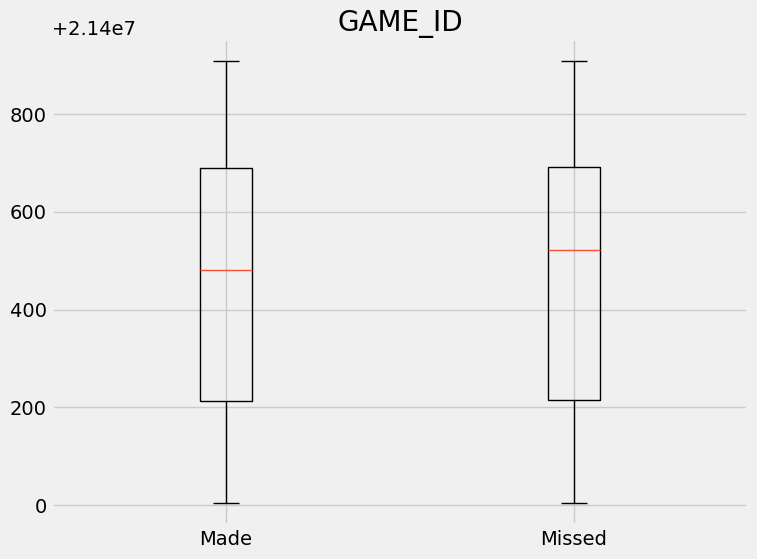

In [60]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['GAME_ID'], shotMissed['GAME_ID']], 0, 'gD')

plt.title('GAME_ID', fontsize=20)

labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

**GAME_ID**'s purpose is to serve as an identifier for a particular game. As such it should not have any predictive power - this is indeed what we observe in the above plot: there is no significan difference between the distributions for the two outcomes of interest.


<font size="4">**SHOT_NUMBER**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

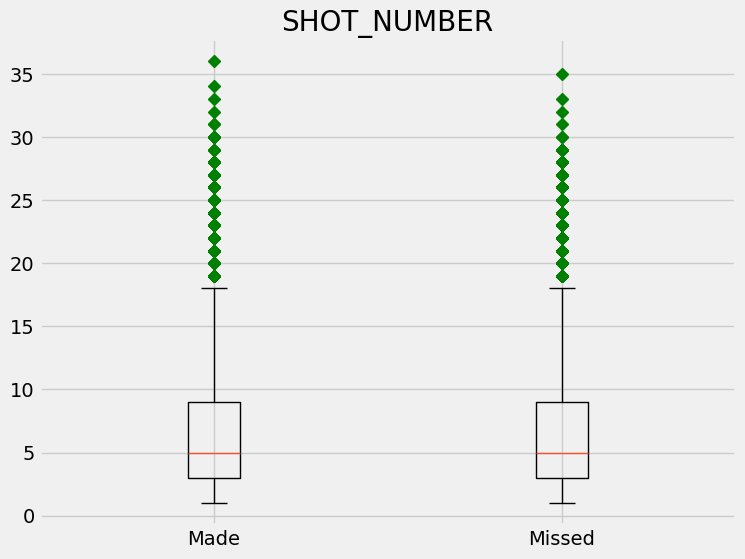

In [61]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['SHOT_NUMBER'], shotMissed['SHOT_NUMBER']], 0, 'gD')

plt.title('SHOT_NUMBER', fontsize=20)

labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

There isn't any significant difference between the two cases of interest for this feature.


<font size="4">**PERIOD**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

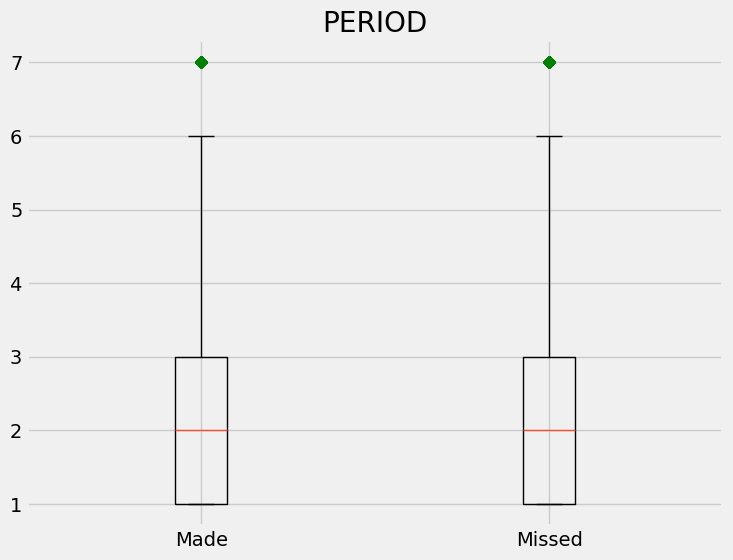

In [62]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['PERIOD'], shotMissed['PERIOD']], 0, 'gD')

plt.title('PERIOD', fontsize=20)

labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

No significant difference between the two cases of interest for this feature.


<font size="4">**GAME_CLOCK**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

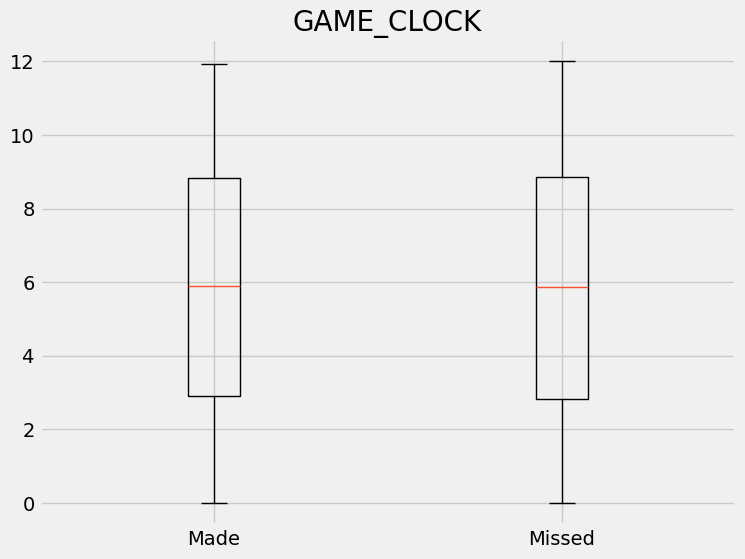

In [63]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['GAME_CLOCK'], shotMissed['GAME_CLOCK']], 0, 'gD')

plt.title('GAME_CLOCK', fontsize=20)

labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

No significant difference between the two cases of interest for this feature.


<font size="4">**SHOT_CLOCK**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

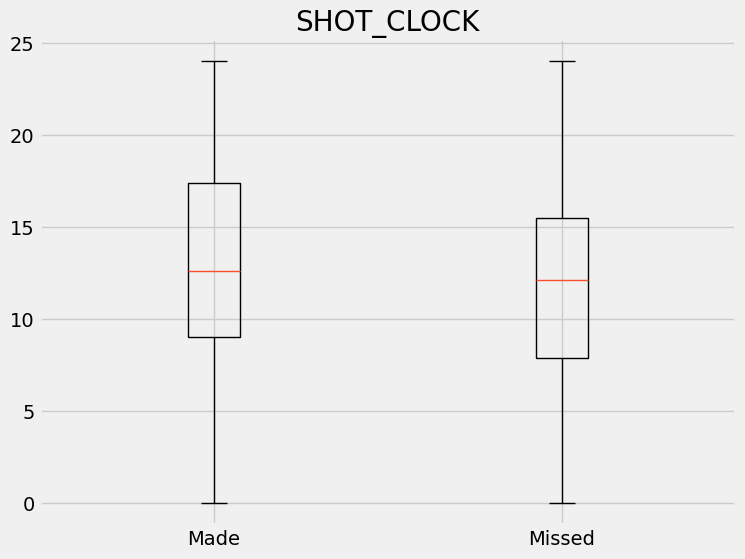

In [64]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['SHOT_CLOCK'], shotMissed['SHOT_CLOCK']], 0, 'gD')

plt.title('SHOT_CLOCK', fontsize=20)

labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

There is some difference between the two cases. Let's examine the corresponding histograms: 

Text(0.5, 1.0, 'SHOT_CLOCK')

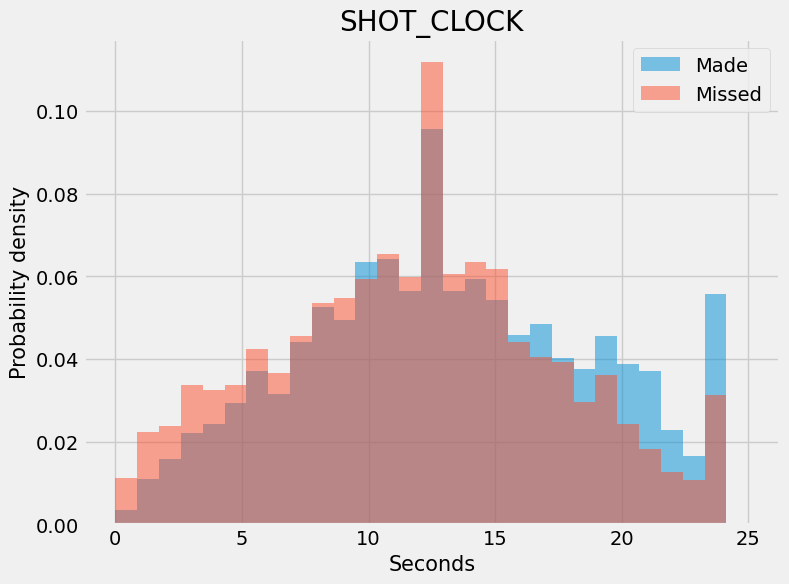

In [65]:
bins = np.linspace(0, 25, 30)

plt.hist(shotMade['SHOT_CLOCK'], bins, alpha=0.5, density=True, label='Made')
plt.hist(shotMissed['SHOT_CLOCK'], bins, alpha=0.5, density=True, label='Missed')
plt.legend(loc='upper right')
plt.ylabel('Probability density', fontsize=15)
plt.xlabel('Seconds', fontsize=15)
plt.title('SHOT_CLOCK', fontsize=20)

We can see that the distributions for the two cases overlap to a large degree; however, shots made for large values of the shot clock (that is, shortly after the player gets the ball) have a higher probability of being made, whilst those shots made towards the end of the 24-seconds period have a higher probability of being missed.


<font size="4">**DRIBBLES**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

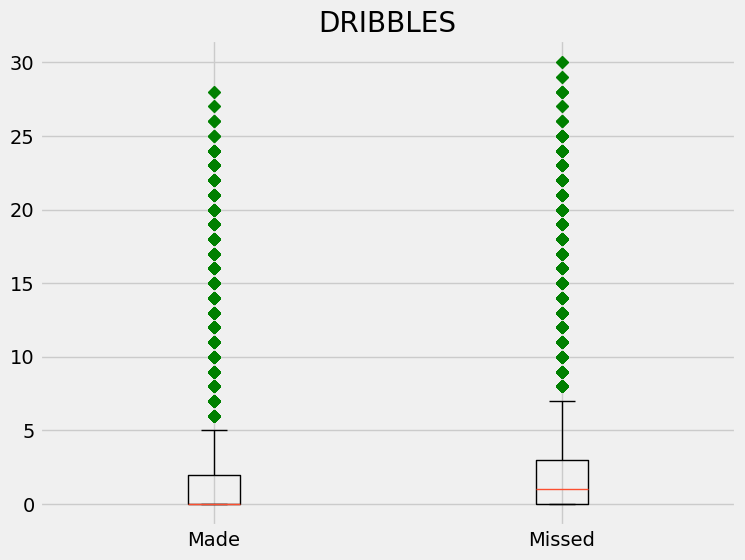

In [66]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['DRIBBLES'], shotMissed['DRIBBLES']], 0, 'gD')

plt.title('DRIBBLES', fontsize=20)

labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

This plot hints at shots that are made requiring a slightly smaller number of dribbles.

Text(0.5, 1.0, 'DRIBBLES')

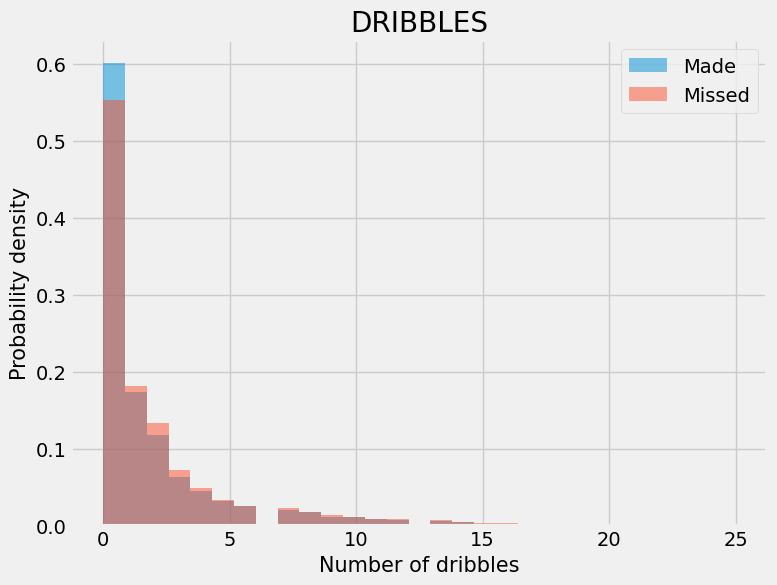

In [67]:
bins = np.linspace(0, 25, 30)

plt.hist(shotMade['DRIBBLES'], bins, alpha=0.5, density=True, label='Made')
plt.hist(shotMissed['DRIBBLES'], bins, alpha=0.5, density=True, label='Missed')
plt.legend(loc='upper right')
plt.xlabel('Number of dribbles', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.title('DRIBBLES', fontsize=20)

The distributions for the two cases overlap to a large degree, however the impression from the box-and-whiskers plot is confirmed here: shots taken after a small number of dribbles have a higher probability of being made.

<font size="4">**TOUCH_TIME**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

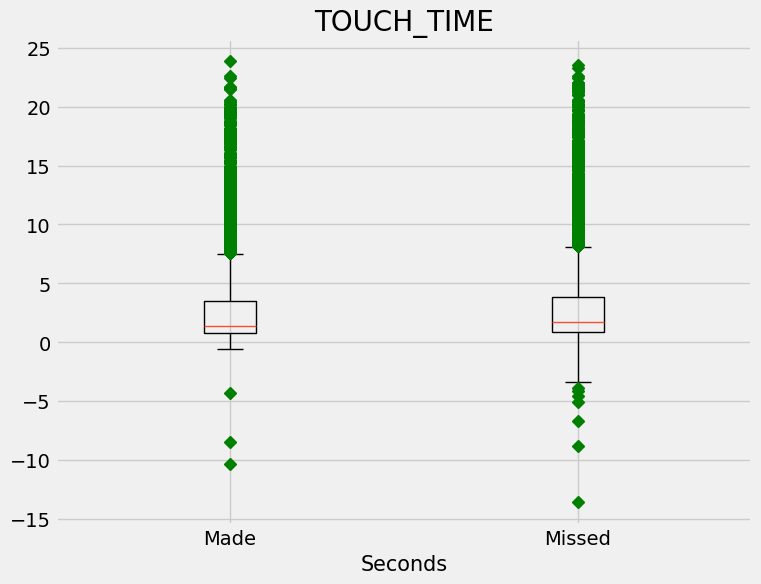

In [68]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['TOUCH_TIME'], shotMissed['TOUCH_TIME']], 0, 'gD')

plt.title('TOUCH_TIME', fontsize=20)
plt.xlabel('Seconds', fontsize=15)
labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

There is a bit of a difference between the two distributions.

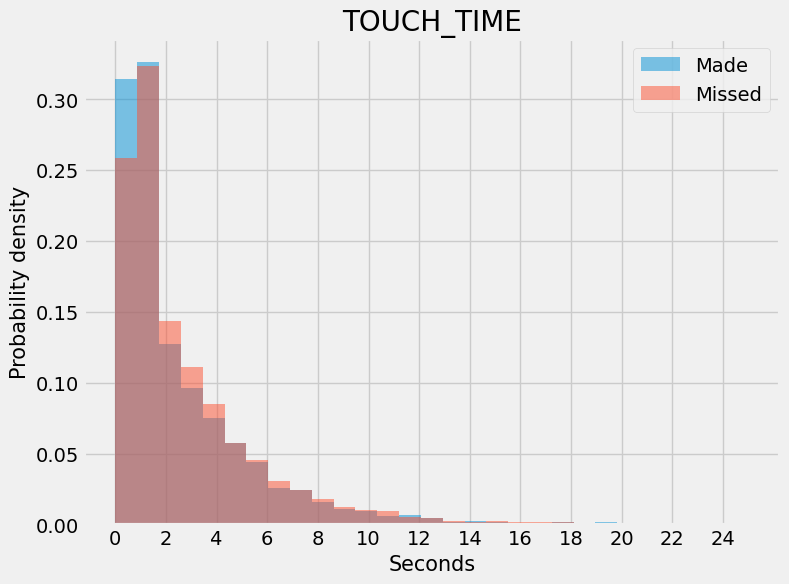

In [69]:
bins = np.linspace(0, 25, 30)

plt.hist(shotMade['TOUCH_TIME'], bins, alpha=0.5, density=True, label='Made')
plt.hist(shotMissed['TOUCH_TIME'], bins, alpha=0.5, density=True, label='Missed')
plt.legend(loc='upper right')
plt.xlabel('Seconds', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.title('TOUCH_TIME', fontsize=20)
plt.xticks(np.arange(0, 25, 2.0));

We can see that shots taken after short touch times (less that 1 second) have a slightly larger probability of being made. This hints at the element of surprise!

<font size="4">**SHOT_DIST**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

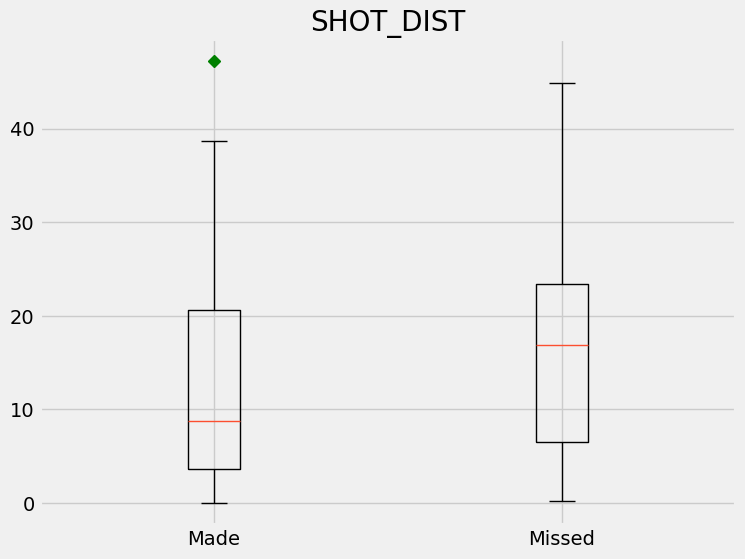

In [70]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['SHOT_DIST'], shotMissed['SHOT_DIST']], 0, 'gD')

plt.title('SHOT_DIST', fontsize=20)
labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

This feature looks promising: there is a definite difference between the distributions. Let's look at the corresponding histograms:

Text(0.5, 1.0, 'SHOT_DIST')

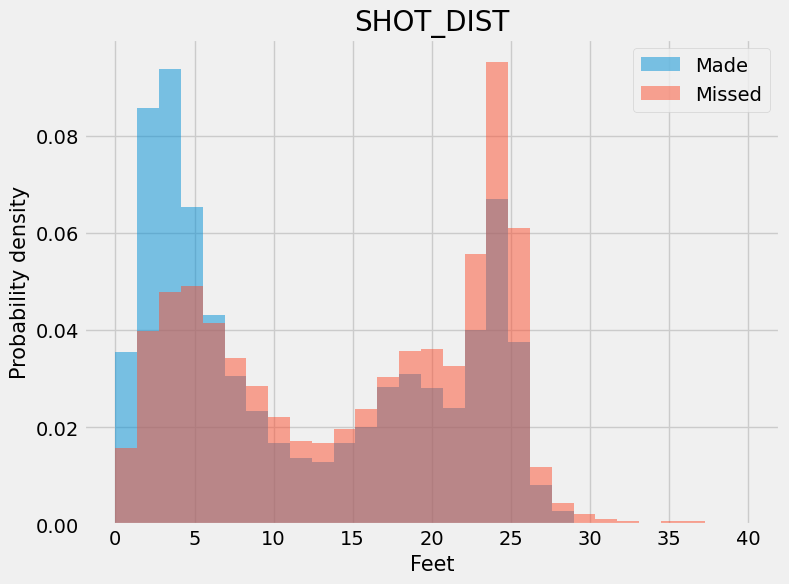

In [71]:
bins = np.linspace(0, 40, 30)

plt.hist(shotMade['SHOT_DIST'], bins, alpha=0.5, density=True, label='Made')
plt.hist(shotMissed['SHOT_DIST'], bins, alpha=0.5, density=True, label='Missed')
plt.xlabel('Feet', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.legend(loc='upper right')
plt.title('SHOT_DIST', fontsize=20)

Shots taken from short distances have a higher probability of being made; on the flip side, shots taken from very long distances have a higher probability of being missed. This is very much in alignment with our intuition. Shots from distances larger than 30 feet have a negligible probability of being made.

<font size="4">**CLOSE_DEF_DIST**:</font>

[Text(1, 0, 'Made'), Text(2, 0, 'Missed')]

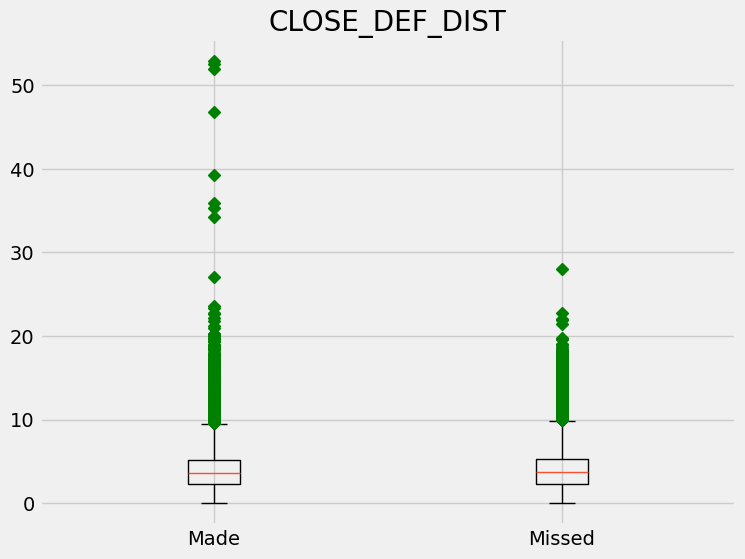

In [72]:
fig, ax = plt.subplots(figsize=(8,6))

plt.boxplot([shotMade['CLOSE_DEF_DIST'], shotMissed['CLOSE_DEF_DIST']], 0, 'gD')

plt.title('CLOSE_DEF_DIST', fontsize=20)

labels = ['Made', 'Missed']
ax.set_xticklabels(labels, fontsize=14)

For most distances there doesn't seem to be a big difference between cases, however for distances greater than 25 feet there is a distinct chance of the shot being made. Again, this is intuitively understandable: the further away the defender, the higher the chances of making the shot.

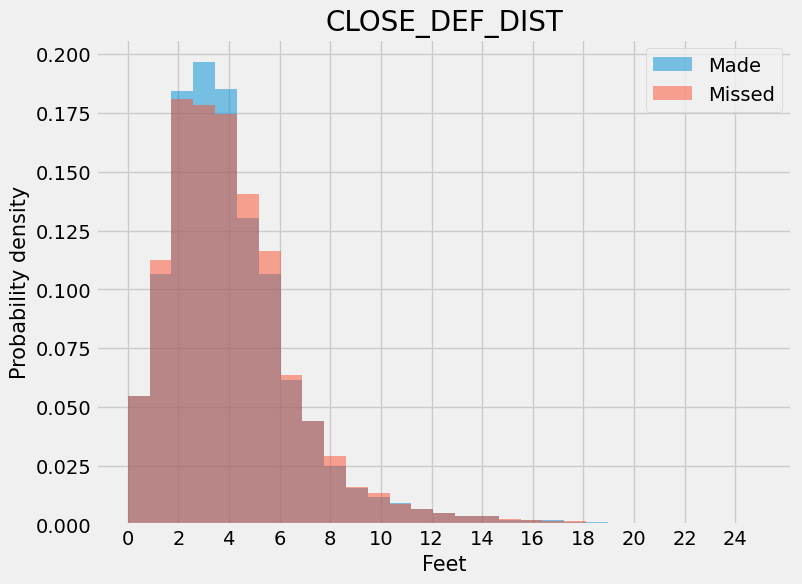

In [73]:
bins = np.linspace(0, 25, 30)

plt.hist(shotMade['CLOSE_DEF_DIST'], bins, alpha=0.5, density=True, label='Made')
plt.hist(shotMissed['CLOSE_DEF_DIST'], bins, alpha=0.5, density=True, label='Missed')
plt.legend(loc='upper right')
plt.xlabel('Feet', fontsize=15)
plt.ylabel('Probability density', fontsize=15)
plt.title('CLOSE_DEF_DIST', fontsize=20)
plt.xticks(np.arange(0, 25, 2.0));

Interestingly, we see that having a defender between 2 and 4 feet away is associated with a slightly higher probability of making the shot than missing it. This is rather counterintuitive!

<font size="4">**PTS_TYPE**:</font>

Nothing to see here - we know what happens if the shot is missed or made!

## 4.2.- Comparison between 'shot made' and 'shot missed' for categorical features

In [74]:
categorical_columns

['MATCHUP', 'LOCATION', 'CLOSEST_DEFENDER', 'player_name']

<font size="4">**LOCATION:**:</font>

Let's start by taking a look at the distribution of **LOCATION** for both outcomes:

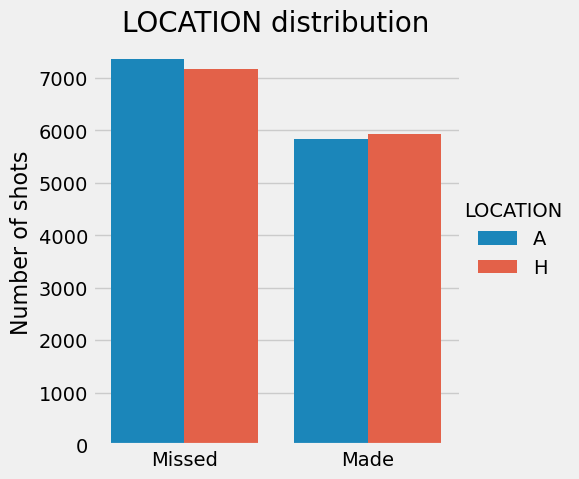

In [75]:
g = sns.catplot(x="FGM", hue='LOCATION', data=shotData, kind='count') 
plt.xlabel('')
plt.ylabel('Number of shots', fontsize=16)
plt.title('LOCATION distribution', fontsize=20)
g.set_xticklabels(['Missed', 'Made']);

We find that compared with the number of missed shots, a smaller number of made shots is seen regardless of a team playing away or at home. This is consistent with what was seen in the distribution of the target.

<font size="4">**player_name**:</font>

Given the relatively large number of players in the dataset (281), we will concentrate in examining the difference in the count of shots made vs. shots missed for every player. We will call this difference **player_margin**, and it can be interpreted as a measure of a player's shooting performance.

In [76]:
shotsPerPlayer = shotData.groupby(["player_name", 'FGM']).agg(
    shots = ("FGM", "count"),
).unstack().reset_index()

Using the above table, we will now calculate player margin:

In [77]:
shotsPerPlayer['player_margin'] = shotsPerPlayer['shots'][1] - shotsPerPlayer['shots'][0]

Using the player margin we can now divide players into those with a positive margin and those with a negative margin.

In [78]:
playersMakingShots = shotsPerPlayer[shotsPerPlayer['player_margin'] >= 0].\
                     sort_values(by="player_margin", ascending=False)

In [79]:
playersMissingShots = shotsPerPlayer[shotsPerPlayer['player_margin'] < 0].\
                     sort_values(by="player_margin")

In [80]:
playersMakingShots.head()

player_name shots      player_margin
FGM                        0    1              
71      derrick favors    53   87            34
66      deandre jordan    29   61            32
19       anthony davis    72  102            30
270     tyson chandler    23   44            21
137  jonas valanciunas    35   54            19

In [81]:
playersMissingShots.head()

player_name shots     player_margin
FGM                        0   1              
146       kemba walker   119  75           -44
264         trey burke   103  60           -43
57      damian lillard   110  68           -42
167  lamarcus aldridge   121  80           -41
158        kobe bryant    92  52           -40

The above tables allows us to identify the top and bottom performers in terms of making/missing shots.

In [82]:
playersMakingShots.shape

(63, 4)

In [83]:
playersMissingShots.shape

(218, 4)

We see that out of the 281 players represented in the data, 22.4% of them make more shots than they miss, whilst the remaining 77.6% miss more shots thatn they make. Let's have a look at the distribution of the player margin:

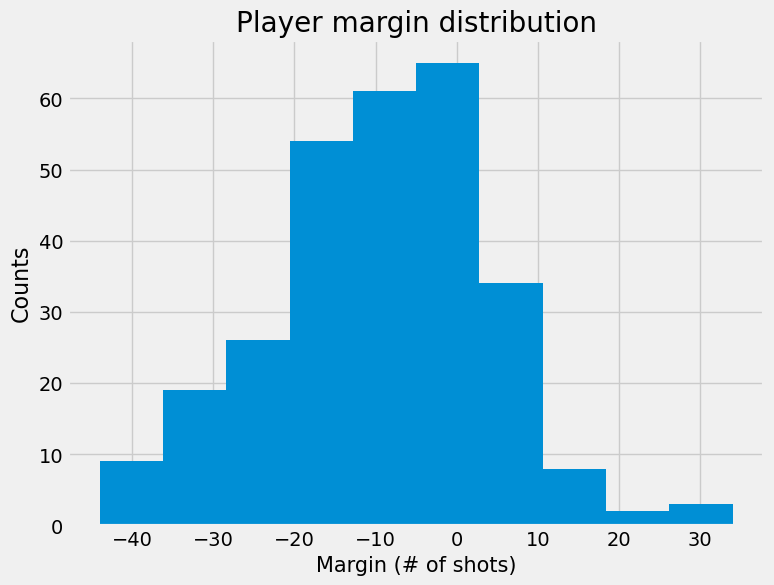

In [84]:
shotsPerPlayer['player_margin'].hist()
plt.xlabel('Margin (# of shots)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Player margin distribution', fontsize=20);

In [85]:
shotsPerPlayer.describe()

shots             player_margin
FGM             0           1              
count  281.000000  281.000000    281.000000
mean    51.736655   41.911032     -9.825623
std     27.992506   23.496411     13.265753
min      3.000000    4.000000    -44.000000
25%     29.000000   23.000000    -18.000000
50%     47.000000   38.000000     -9.000000
75%     72.000000   57.000000     -2.000000
max    145.000000  120.000000     34.000000

As already observed, in average players miss more shots than they make. Looking at the distribution, it is apparent that players with a positive margin are found in the upper quartile of the distribution.

<font size="4">**CLOSEST_DEFENDER**:</font>

The presence of competent defenders can influence the outcome of the shot; this is an idea that we will examine now in terms of the margin idea defined above.

In [86]:
shotsPerDefender = shotData.groupby(["CLOSEST_DEFENDER", 'FGM']).agg(
    shots = ("FGM", "count"),
).unstack().reset_index()

In [87]:
shotsPerDefender['defender_margin'] = shotsPerDefender['shots'][1] - shotsPerDefender['shots'][0]

We can presume that competent defenders will be those associated with a negative margin (when these players are defending, more shots are missed than made), while those who are not will be associated with a positive margin (when defending, more shots are made than missed).

In [88]:
defendersAllowingShots = shotsPerDefender[shotsPerDefender['defender_margin'] >= 0].\
                         sort_values(by="defender_margin", ascending=False)

In [89]:
defendersPreventingShots = shotsPerDefender[shotsPerDefender['defender_margin'] < 0].\
                           sort_values(by="defender_margin")

In [90]:
defendersAllowingShots.head()

CLOSEST_DEFENDER shots       defender_margin
FGM                         0     1                
142      Frye, Channing  66.0  81.0            15.0
404  Valanciunas, Jonas  55.0  68.0            13.0
314     Oladipo, Victor  49.0  61.0            12.0
24       Augustin, D.J.  31.0  42.0            11.0
194       Hill, Solomon  47.0  58.0            11.0

In [91]:
defendersPreventingShots.head()

CLOSEST_DEFENDER shots       defender_margin
FGM                      0     1                
164  Green, Draymond  83.0  34.0           -49.0
413    Walker, Kemba  82.0  40.0           -42.0
322      Paul, Chris  75.0  35.0           -40.0
101   Davis, Anthony  73.0  39.0           -34.0
374      Smith, Josh  98.0  64.0           -34.0

The above tables help us identify players which are effective as defenders, as well as those who are not.


In [92]:
defendersAllowingShots.shape

(126, 4)

In [93]:
defendersPreventingShots.shape

(302, 4)

Out of the 443 closest defenders found in the dataset, we find that we have defender margins values for 428 players; we have a few defenders for which we have absent values for the shots they have allowed or prevented, hence the difference in counts:

In [94]:
shotsPerDefender[shotsPerDefender['shots'][1].isnull()]

CLOSEST_DEFENDER shots     defender_margin
FGM                        0   1                
32        Barron, Earl   1.0 NaN             NaN
113  Dos Santos, Atila   4.0 NaN             NaN
262       Lucas, Kalin   1.0 NaN             NaN
293     Moore, E'Twaun   1.0 NaN             NaN
341     Rice Jr., Glen   3.0 NaN             NaN
402         Udoh, Ekpe   2.0 NaN             NaN
408       Vonleh, Noah   3.0 NaN             NaN

In [95]:
shotsPerDefender[shotsPerDefender['shots'][0].isnull()]

CLOSEST_DEFENDER shots      defender_margin
FGM                             0    1                
46            Blair, DeJuan   NaN  4.0             NaN
73            Capela, Clint   NaN  1.0             NaN
81             Cherry, Will   NaN  3.0             NaN
84           Claver, Victor   NaN  1.0             NaN
115  Douglas-Roberts, Chris   NaN  4.0             NaN
188           Henry, Xavier   NaN  2.0             NaN
237              Kirk, Alex   NaN  1.0             NaN
431        Williams, Reggie   NaN  2.0             NaN

Therefore, 29.4% of the defenders do not seem to be effective at preventing or blocking shots, whilst the remaining 70.6% were able to prevent shots from being made. We will now take a look at the distribution of player margins for closest defenders.

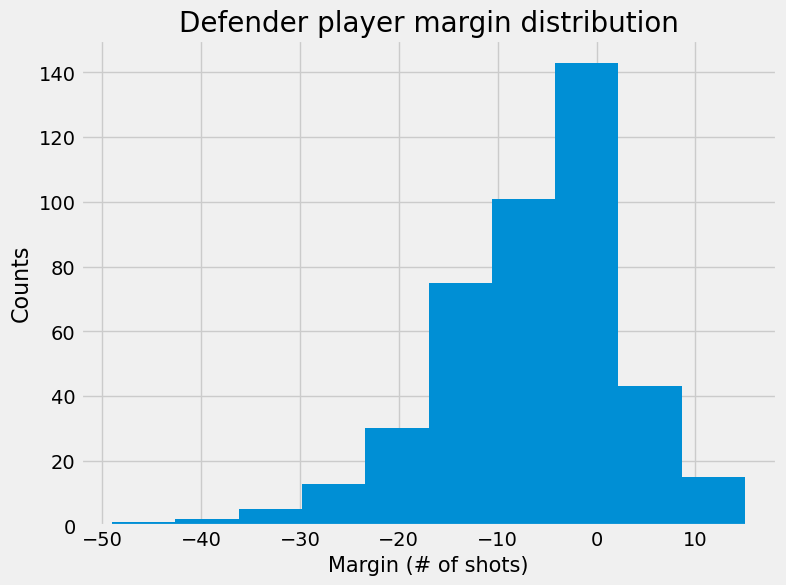

In [96]:
shotsPerDefender['defender_margin'].hist()
plt.xlabel('Margin (# of shots)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Defender player margin distribution', fontsize=20);

In [97]:
shotsPerDefender['defender_margin'].describe()

count    428.000000
mean      -6.457944
std        9.437610
min      -49.000000
25%      -12.000000
50%       -5.000000
75%        0.000000
max       15.000000
Name: defender_margin, dtype: float64

As previously seen, most defenders seem to be effective at preventing shots from being made. A more accurate picture can be obtained by combining this information with **CLOSE_DEF_DIST**; we will not do this in this first pass at the dataset.

<font size="4">**MATCHUP:**</font>


**MATCHUP** contains the date of the game plus 3-letter acronyms corresponding to the names of the teams. This last information can be relevant to our objective: **are there teams which are more effective at making shots or preventing shots from being made?**

Let's inspect a couple of examples for **MATCHUP**:

In [98]:
shotData['MATCHUP'][112]

'DEC 03, 2014 - CHA vs. CHI'

In [99]:
shotData['MATCHUP'][0]

'MAR 04, 2015 - CHA @ BKN'

In the above examples, the first team (CHA) is the one taking the shot, whilst the second team (BKN or CHI) is the defending team. The 'vs.' mean that the first team is playing at its home (H) location, whilst the ampersand mean that the first team is playing at the away (A) location. 

In this first approach we will asume that the date of the matchup is irrelevant (this is intuitive from a domain knowledge point of view); therefore we will drop the date from  **MATCHUP** to engineer a new feature with only the acronyms for the teams.

In [100]:
 shotData['TEAMS'] = shotData['MATCHUP'].str.split(pat = " - ").str[1]

Now we can drop **MATCHUP** from the dataset:

In [101]:
shotData.drop(columns="MATCHUP", inplace=True)

Since the information regarding if a team is playing Home or Away is already present in **LOCATION**, we will remove this information from **TEAMS** by substituting the ampersand by 'vs.':

In [102]:
shotData['TEAMS'] = shotData['TEAMS'].str.replace(' @ ', ' vs. ')

Now we will obtain the number of shots made by each combination of teams:

In [103]:
shotsPerTeam = shotData.groupby(["TEAMS", 'FGM']).agg(
    shots = ("FGM", "count"),
).unstack().reset_index()

Just like we did for players and defenders, we will compute a team margin, which we will use to identify teams that make shots and teams that prevent shots from being made:

In [104]:
shotsPerTeam['team_margin'] = shotsPerTeam['shots'][1] - shotsPerTeam['shots'][0]

In [105]:
teamsMakingShots = shotsPerTeam[shotsPerTeam['team_margin'] >= 0].sort_values(by='team_margin', ascending=False)

In [106]:
teamsPreventingShots = shotsPerTeam[shotsPerTeam['team_margin'] < 0].sort_values(by='team_margin')

In [107]:
teamsMakingShots.head()

TEAMS shots     team_margin
FGM                  0   1            
2    ATL vs. CLE    26  40          14
181  MIL vs. PHI    59  73          14
138  LAC vs. ORL    70  84          14
118  HOU vs. ORL    22  36          14
103  GSW vs. LAC    28  40          12

In [108]:
teamsPreventingShots.head()

TEAMS shots     team_margin
FGM                  0   1            
163  MIA vs. CHA    99  55         -44
25   BOS vs. ATL    91  51         -40
146  LAL vs. NOP    96  59         -37
266  POR vs. LAC    97  60         -37
48   CHA vs. SAS    95  62         -33

In [109]:
teamsMakingShots.shape

(67, 4)

In [110]:
teamsPreventingShots.shape

(263, 4)

Of all the 330 combinations of teams in the data, there is a 20.3% of cases with a positive team margin (the first team is effective at making shots), with a 79.7% of cases with a negative team margin (the second team is effective at preventing shots from being made). Let's examine the distribution of the team margin:

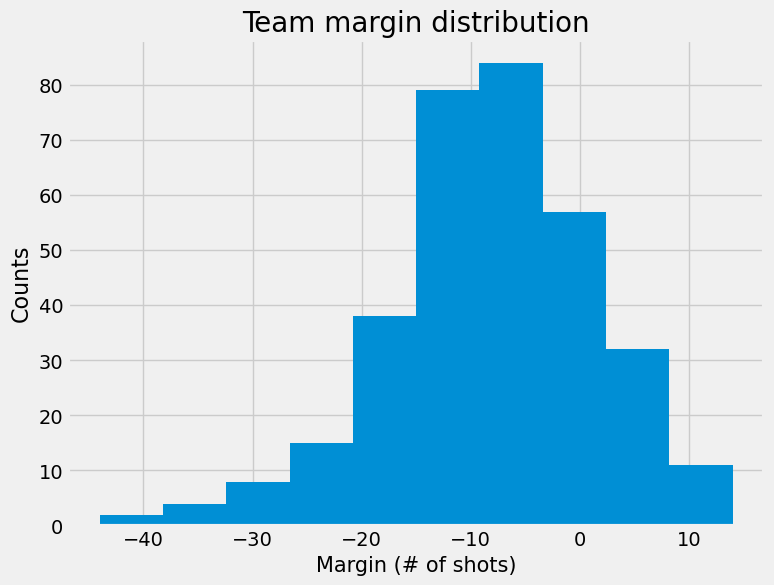

In [111]:
shotsPerTeam['team_margin'].hist()
plt.xlabel('Margin (# of shots)', fontsize=15)
plt.ylabel('Counts', fontsize=16)
plt.title('Team margin distribution', fontsize=20);

In [112]:
shotsPerTeam['team_margin'].describe()

count    330.000000
mean      -8.366667
std        9.763874
min      -44.000000
25%      -14.000000
50%       -8.000000
75%       -3.000000
max       14.000000
Name: team_margin, dtype: float64

It can be seen that the shape of the team margin distribution is similar to that of the defender margin distribution. In an average sense, in most cases the defending teams are moderately successful at preventing shots from being made. Team combinations in which the attacking team is successful at making shots are found in the upper 25% of the distribution. 

# 5.- Predictive model v0

We will now train a machine learning model to predict the outcome of a shot. At this stage we will chose a tree-based model, as they a) do not require numerical feature scaling and b) using an ordinal encoding for the categorical features is fine even if the encoding results in an arbitrary ordering.

Let's put together a machine learning pipeline for the model:

In [113]:
numerical_columns = numerical_columns_selector(shotData)
categorical_columns = categorical_columns_selector(shotData)

In [114]:
# split data into features & target
target_name = "FGM"
features, target = shotData.drop(columns=target_name), shotData[target_name]

In [115]:
# split into training & testing set
data_train, data_test, target_train, target_test = \
            train_test_split(features, shotData[target_name], random_state=RANDOM_STATE)

In [116]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer

# as there are categories that may not be present in the test data, we will set the 'handle_unknown'
# parameter for the ordinal encoder
categorical_preprocessor = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

# no preprocessing required for numerical variables 
preprocessor = ColumnTransformer(
    [('cat_preprocessor', categorical_preprocessor, [1, 10, 12, 13])],
    remainder='passthrough', sparse_threshold=0)

In this first approach we will select a random forest classifier, as it is a model that performs quite well out of the box.

In [117]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=RANDOM_STATE))
])

Of all the hyperparameters that can be tuned in a random forest classifier, we will only tune two for the sake of time: the number of trees in the forest and the maximum depth of the trees. A nested cross validation approach will be used.

In [118]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'classifier__n_estimators': (5, 10, 20),
    'classifier__max_depth': (3, 5, 10)
}

model_grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=2, cv=5)

A good metric for classification tasks is log loss, as it not only penalises wrong predictions but also predictions which are not confident (in other words, predictions that do not lean clearly towards 0 or 1). A lower log loss means a more acurate model.

In [119]:
from sklearn.model_selection import cross_validate

cv_results = cross_validate(model_grid_search, data_train.values, target_train.values, cv=5, 
                            scoring='neg_log_loss', n_jobs=2, 
                            return_train_score=True, error_score="raise", return_estimator=True)

In [120]:
cv_results_DF = pd.DataFrame(cv_results)
cv_results_DF.head()

,fit_time,score_time,estimator,test_score,train_score
0,4.868208,0.027993,"GridSearchCV(cv=5,\n estimator=Pip...",-0.655777,-0.649878
1,4.975706,0.028233,"GridSearchCV(cv=5,\n estimator=Pip...",-0.658566,-0.579856
2,4.914485,0.018020,"GridSearchCV(cv=5,\n estimator=Pip...",-0.658944,-0.647070
3,4.841064,0.018196,"GridSearchCV(cv=5,\n estimator=Pip...",-0.655584,-0.648667
4,4.297912,0.018876,"GridSearchCV(cv=5,\n estimator=Pip...",-0.655036,-0.648500


The above results look quite good: training and testing scores are close to each other.

In [121]:
print(f"The average log loss is "
      f"{-cv_results['test_score'].mean():.3f} +/- " \
      f"{cv_results['test_score'].std():.3f}")

The average log loss is 0.657 +/- 0.002


Very little standard deviation across folds - nice!

In [122]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]):
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'classifier__max_depth': 5, 'classifier__n_estimators': 20}
Best hyperparameters for fold #2:
{'classifier__max_depth': 10, 'classifier__n_estimators': 20}
Best hyperparameters for fold #3:
{'classifier__max_depth': 5, 'classifier__n_estimators': 20}
Best hyperparameters for fold #4:
{'classifier__max_depth': 5, 'classifier__n_estimators': 20}
Best hyperparameters for fold #5:
{'classifier__max_depth': 5, 'classifier__n_estimators': 20}


In light of the above results, we will train a forest with 20 trees with a maximum depth of 5.

In [123]:
model = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(n_estimators = 20, max_depth=5 ,random_state=RANDOM_STATE))
])

In [124]:
model.fit(data_train.values, target_train.values)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough', sparse_threshold=0,
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  [1, 10, 12, 13])])),
                ('classifier',
                 RandomForestClassifier(max_depth=5, n_estimators=20,
                                        random_state=801))])

## 5.1.- Performance on test set

In order to select a suitable decision threshold for our classification model, we will first generate a precision-recall plot:

In [125]:
probas = model.predict_proba(data_test.values)[:, 1]

In [126]:
from sklearn.metrics import precision_recall_curve, precision_score, recall_score

precision, recall, thresholds = precision_recall_curve(target_test, probas)

Text(0.5, 0, 'Recall')

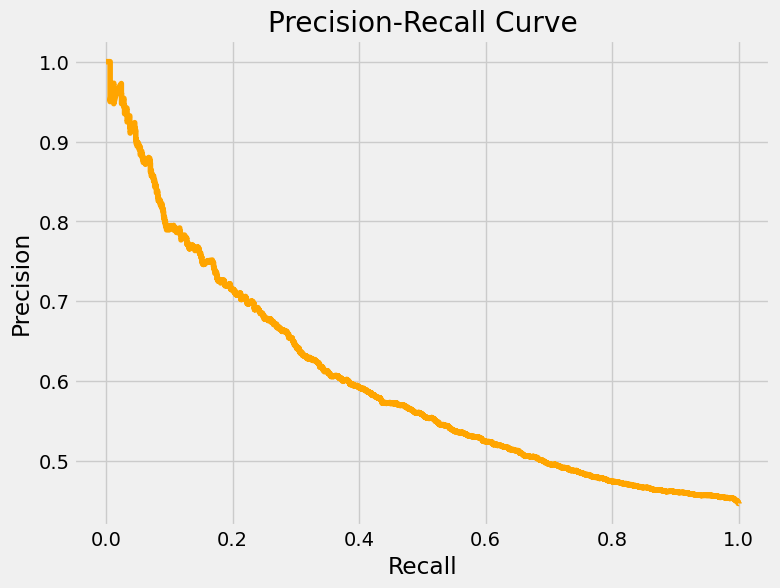

In [127]:
#create precision recall curve
fig, ax = plt.subplots()
ax.plot(recall, precision, color='orange')

#add axis labels to plot
ax.set_title('Precision-Recall Curve')
ax.set_ylabel('Precision')
ax.set_xlabel('Recall')

In all classification models such as the one we have built there is a trade-off between precision and recall determined by the decision threshold of the model. Selecting the decision threshold is a business decision that depends on this trade-off.

A possible decision threshold in this business case would be to select a decision threshold that gives us reasonable confidence in the predictions provided by the model; for example, we want the model to be right 75% of the time when it predicts that a shot will be made - in other words, we require a 0.75 precision. The above plot shows us that for that precision we would have a recall around 17%, meaning that of all the shots that will be made, the model will predict 17% of them. 

Of course, other thresholds can be selected depending on the appetite for risk in the business.

In [128]:
# let's find the index that is closest to a 75% precision within a 0.05 tolerance
idx = next(i for i, _ in enumerate(precision) if np.isclose(_, 0.75, 0.01))

In [129]:
print(f"The decision threshold is "
      f"{thresholds[idx]:.3f} resulting in a precision of " \
      f"{precision[idx]:.3f}")

The decision threshold is 0.604 resulting in a precision of 0.743


In [130]:
threshold = thresholds[idx]
predictions = [1 if probas[k] >= threshold else 0 for k in np.arange(len(probas))]

In [131]:
precision_score(target_test, predictions)

0.7429420505200595

In [132]:
recall_score(target_test, predictions, )

0.17018379850238258

We see that with the selected decision threshold we obtain a 74% precision and a 17% recall on the test set. The threshold can be further tweaked to get closer to the 75% precision goal.

Let's have a look at the confusion matrix for the selected decision threshold:

In [133]:
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(target_test, predictions)
confusion

array([[3468,  173],
       [2438,  500]])

Text(0.5, 1.0, 'Random Forest Model')

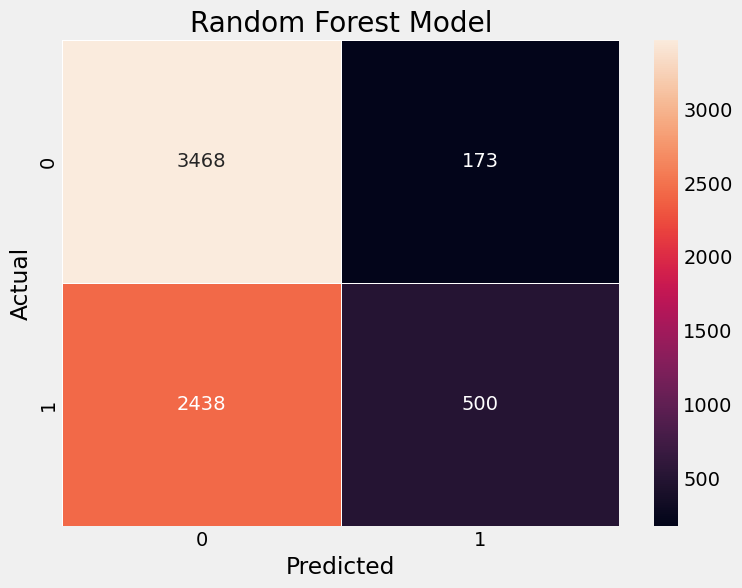

In [134]:
fig, ax = plt.subplots(figsize=(8,6))
ax = sns.heatmap(confusion, annot=True, fmt="d", linewidths=.5)
ax.set(xlabel='Predicted', ylabel='Actual')
ax.set_title('Random Forest Model')

Due to the selection of the decision threshold we see that we have a large number of false negatives - thereby impacting the recall.

## 5.2.- Feature importances

We want to know which features impact our predictions - in other words, which factors determine if a shot will be made or not. To answer this question, we will use a technique called permutation importance.

In [135]:
from sklearn.inspection import permutation_importance

r = permutation_importance(model, data_test.values, target_test, n_repeats=30, random_state=RANDOM_STATE)

In [136]:
r_sub = dict((k, r[k]) for k in ('importances_mean', 'importances_std'))
permutation_importances_df = pd.DataFrame(r_sub)
permutation_importances_df['Features'] = data_test.columns
permutation_importances_df.sort_values(by='importances_mean', ascending=False, inplace=True)
permutation_importances_df

,importances_mean,importances_std,Features
8,0.062841,0.004699,SHOT_DIST
9,0.006855,0.002012,PTS_TYPE
11,0.005452,0.001882,CLOSE_DEF_DIST
5,0.003638,0.001472,SHOT_CLOCK
7,0.003045,0.002120,TOUCH_TIME
6,0.000735,0.001091,DRIBBLES
12,0.000339,0.000482,player_name
2,0.000152,0.000672,SHOT_NUMBER
1,0.000111,0.000280,LOCATION
10,-0.000127,0.000971,CLOSEST_DEFENDER


In the above table we see that, by and large and quite intuitively, the feature that has the largest impact on the predictions is **SHOT_DIST**, followed by **PTS_TYPE** and **CLOSE_DEF_DIST**. 

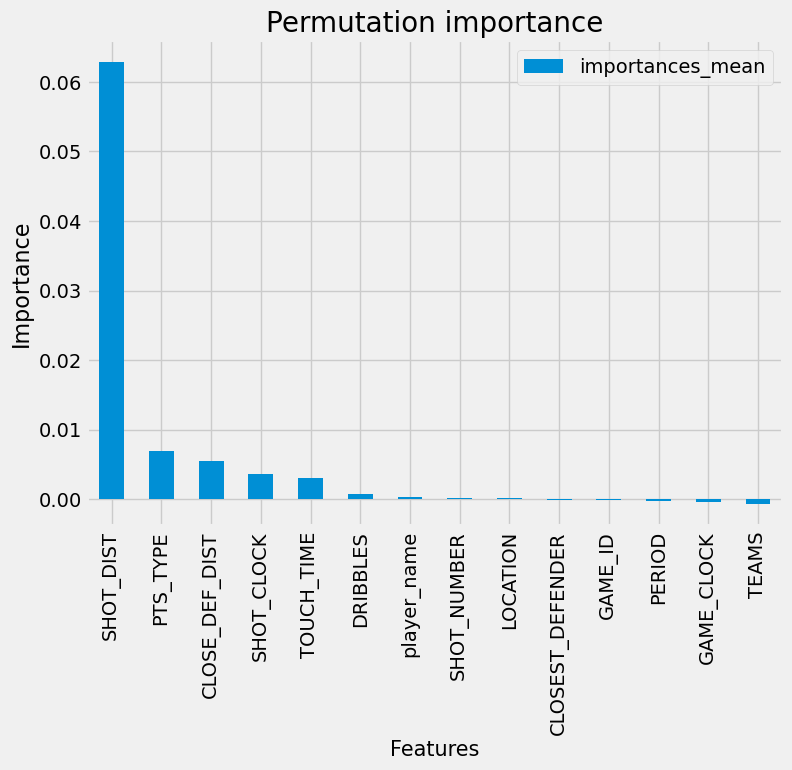

In [137]:
permutation_importances_df.plot.bar(x='Features', y = 'importances_mean')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=16)
plt.title('Permutation importance', fontsize=20);

# 6.- Model implementation

Given that this model is goint to be used to predict events that will take place in a short span of time, it is absolutely necessary that we deploy a fast model and that the predictions are served through a fast interface.

In this section we will build and test an application that takes shot data that follow the same format provided in the supplied dataset. The application will be made available through a lightweight API built with Flask.

## 6.1.- Model pickling

First we will produce a pickle file for the model's pipeline:

In [138]:
import pickle

file_Name = "shotPredictionModel"
fileObject = open(file_Name,'wb') 

pickle.dump(model, fileObject)   
fileObject.close()

## 6.2.- Model testing

We have a separate dataset that we will use for testing purposes.

In [139]:
# load data from text file
testData = pd.read_csv('test_data.csv')
testData.drop(columns=['SHOT_RESULT', 'FGM'], inplace=True)

The required data pipeline as well as the basic functionality of the shot prediction application is provided in the following function call, which incorporates all the transformations we applied to the development set in the previous sections of this notebook. The logic of this function call will be included in our API.

In [140]:
def predictShot(df, threshold):
            
    # load pickled model
    loaded_model = pickle.load(open("shotPredictionModel", 'rb'))    
        
    # corrects negative values in TOUCH_TIME    
    df['TOUCH_TIME'] = np.where(df['TOUCH_TIME'] < 0, np.abs(df['TOUCH_TIME']), df['TOUCH_TIME'])

    # drops player_id and CLOSEST_DEFENDER_PLAYER_ID
    df.drop(labels=['player_id', 'CLOSEST_DEFENDER_PLAYER_ID'], inplace=True)
    
    # convert GAME_CLOCK to minutes and fractions of minutes
    df['GAME_CLOCK'] = pd.to_timedelta(df['GAME_CLOCK'])/pd.offsets.Hour(1)
    
    # impute missing values in SHOT_CLOCK
    df['SHOT_CLOCK'] = np.where(np.isnan(df['SHOT_CLOCK']), np.median(df['SHOT_CLOCK']), df['SHOT_CLOCK'])

    # drop features introducing target leakage
    df.drop(labels=['FINAL_MARGIN', 'W', 'PTS'], inplace=True)
    
    # engineer TEAMS feature
    df['TEAMS'] = df['MATCHUP'].split(" - ")[1]
    df.drop(labels="MATCHUP", inplace=True)
    df['TEAMS'] = df['TEAMS'].replace(' @ ', ' vs. ')
               
    # convert to numpy array
    X = df.values
   
    # predict probability of making the shot
    shotProbability = model.predict_proba(X.reshape(1,14))[0][1]

    # shot prediction
    shotMade = 1 if shotProbability >= threshold else 0
    
    return shotMade

We now test our scoring function prototype by using a loop that calls it at intervals described by an exponential distribution with a mean of 1 second. 

In [141]:
# rows of the testing dataframe are fed sequentially to scoring function
predictions = []
predictionTimes = []
threshold = 0.6566
for i in range(len(testData)):  
    
    print('working on line %d' % i)
    
    # simulate exponentially distributed interarrival time, 1 second mean
    time.sleep(random.expovariate(1.0))
    
    # compute prediction time
    start_time = time.time()
    predictions.append(predictShot(testData.iloc[i,:], threshold))
    end_time = time.time()
    
    predictionTimes.append(end_time - start_time)
    
print(predictions)  
print(f"\nThe prediction time is "
      f"{mean(predictionTimes):.3f} +/- " \
      f"{stdev(predictionTimes):.3f} seconds")

working on line 0
working on line 1
working on line 2
working on line 3
working on line 4
working on line 5
working on line 6
working on line 7
working on line 8
working on line 9
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

The prediction time is 0.013 +/- 0.001 seconds


We see that in average it takes the model 0.013 seconds to generate a prediction - this seems acceptable for our current business case.


## 6.3.- Flask API for scoring function


The following is the content of the Python script that will implement the API for the shot prediction model. Note that shot data is to be passed to the API as a JSON object.

In [ ]:
# data is passed in json format to the API!
from flask import Flask, jsonify, request

import numpy as np
import pickle
import Pandas as pd

app = Flask(__name__)
 
@app.route('/predictShot', methods=['POST'])
def predictShot():
    
    # prediction threshold hardcoded for simpliciy - can be read from a 
    # configuration file (e.g., YAML) in production
    threshold = 0.604
    
    # incoming json object
    req_json = request.get_json()
    
    # convert json to Pandas series
    df = pd.Series(req_json)
    
    # load pickled model
    model = pickle.load(open("shotPredictionModel", 'rb'))
    
    # transaction type not associated to fraud
    # corrects negative values in TOUCH_TIME    
    df['TOUCH_TIME'] = np.where(df['TOUCH_TIME'] < 0, np.abs(df['TOUCH_TIME']), df['TOUCH_TIME'])

    # drops player_id and CLOSEST_DEFENDER_PLAYER_ID
    df.drop(labels=['player_id', 'CLOSEST_DEFENDER_PLAYER_ID'], inplace=True)
    
    # convert GAME_CLOCK to minutes and fractions of minutes
    df['GAME_CLOCK'] = pd.to_timedelta(df['GAME_CLOCK'])/pd.offsets.Hour(1)
    
    # impute missing values in SHOT_CLOCK
    df['SHOT_CLOCK'] = np.where(np.isnan(df['SHOT_CLOCK']), np.median(df['SHOT_CLOCK']), df['SHOT_CLOCK'])
    
    # drop features introducing target leakage
    df.drop(labels=['FINAL_MARGIN', 'W', 'PTS'], inplace=True)
    
    # engineer TEAMS feature
    df['TEAMS'] = df['MATCHUP'].split(" - ")[1]
    df.drop(labels="MATCHUP", inplace=True)
    df['TEAMS'] = df['TEAMS'].replace(' @ ', ' vs. ')
    
    # convert to numpy array
    X = df.values
    
    # predict probability of making the shot
    shotProbability = model.predict_proba(X.reshape(1,14))[0][1]

    # shot predition
    shotMade = "MADE" if shotProbability >= threshold else "MISSED"

    # return prediction
    return shotMade   

if __name__ == "__main__": app.run()

Instructions to test this API are provided in the README file.


## 6.4.- Deployment considerations


I recommend the following when deploying the model:

* Data drift is going to be an issue, as it is likely that the statistical distribution of the features seen in production will change on a timescale which is unknown at the moment (my hunch is that it will be monthly or even weekly). Therefore a) the drift of the model needs to be monitored in production, and b) the model should be periodically re-trained and re-deployed.

* To avoid possible dependency and scaling issues, it is highly desirable to deploy the model and the Python modules  used to build it within a container.

# 7.- Wrapping up

## 7.1.- Model v0 next steps

In this first pass a v0 model has been built to addresss our business problem; several things can be done to improve the the model and its explainability:

* Re-train model v0 on a larger amount of data.
* Tune model v0 using additional hyperparameters.
* As model speed is an important consideration, it is advisable to re-train the model on a smaller set of features that can be generated by taking advantage of feature importance and domain knowledge - this will result in a faster model. 
* Consult the business to get a clearer view of the speed required by the model - it may be possible to used ensemble models to achieve higher prediction accuracy if the associated prediction time is acceptable.
* Explore other binary classification models such as Xgboost.
* Find additional external data and merge it with the one used here - in 9 out of 10 cases this results in an improvement of the model.
* Acquire additional domain expertise to engineer new features that take advantage of this knowledge.
* Agree with the business on precision-recall values that provide the desired value.

## 7.2.- Insights gained

The following insights were gleaned from the exploratory analysis of the current dataset:

* Almost 45% of the shots are made.  
* Most players take some 8-9 shots per game. 
* Most matchups end after 4 periods.
* Most shots are taken halfway through the 24-seconds shot window.
* Most of the of shots are taken after at most a couple of dribbles.
* In average, players hold the ball for 2-3 seconds.
* Players tend to take shots that are either close to the hoop or far removed from the hoop.
* 73% of made shots are 2-pointers, the remaining 27% are 3-pointers.
* In most cases, defenders are some 4 feet away from the player taking the shot.
* There are slightly more shots during the last minute of a period, and slightly less during the first minute.
* Shots made shortly after the player gets the ball have a higher probability of being made, whilst those shots made towards the end of the 24-seconds period have a higher probability of being missed.
* Shots taken after a small number of dribbles have a higher probability of being made.
* Shots taken after short touch times (less that 1 second) have a slightly larger probability of being made. 
* Shots taken from short distances have a higher probability of being made; on the flip side, shots taken from very long distances have a higher probability of being missed. 
* Having a defender between 2 and 4 feet away is associated with a slightly higher probability of making the shot than missing it. 
* A smaller number of shots are made regardless of a team playing away or at home.
* Out of the 281 players represented in the data, 22.4% of them make more shots than they miss, whilst the remaining 77.6% miss more shots than they make.
* Players with a positive player margin (making more shots than missing them) are found in the upper quartile of player margin distribution.
* 29.4% of the defenders do not seem to be effective at preventing or blocking shots, whilst the remaining 70.6% were able to prevent shots from being made.
* There is a 20.3% of teams with a positive team margin (the team is effective at making shots), whilst 79.7% of teams have a negative team margin (the team is effective at preventing shots from being made). 
* Team combinations in which the attacking team is successful at making shots are found in the upper 25% of the team margin distribution.

___